<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/10_Milestone_3_Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Get Data:

In [1]:
# Download Bitcoin historical data from GitHub 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-05-30 15:58:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.05s   

2023-05-30 15:58:27 (3.68 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#####readind the downloaded CSV data using Pandas

In [2]:
import pandas as pd

pd_data = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                       parse_dates=["Date"],
                      index_col=["Date"])

# reduce the dataframe to data and cosing price
bitcoin_prices = pd.DataFrame(pd_data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})

# pd_data.info()
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


**Visualize bitcoin historical data**

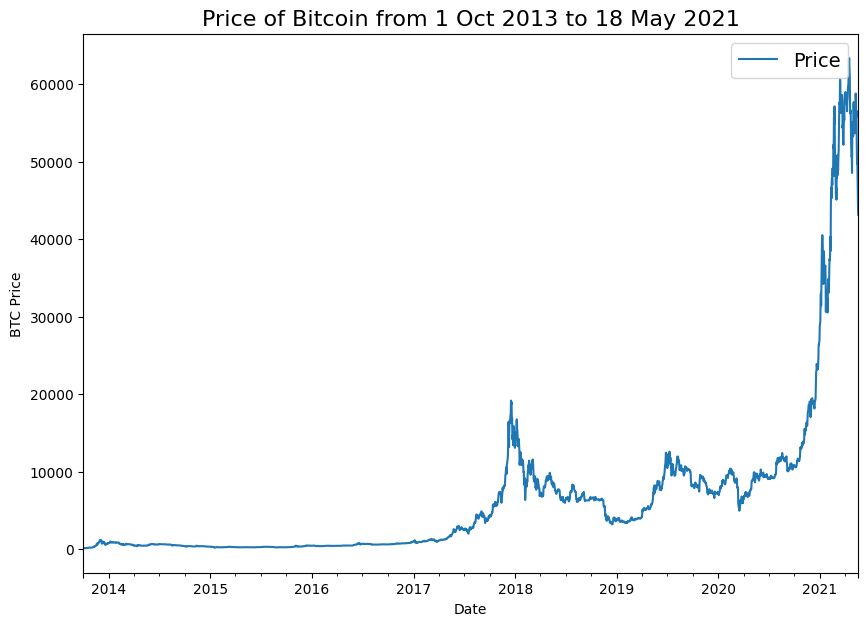

In [3]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

####Importing time series data with Python's CSV module

In [4]:
import csv
from datetime import datetime

time_steps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",'r') as file:
  reader = csv.reader(file)
  next(reader) # skip first line (this gets rid of the column titles)
  for line in reader:
    time_steps.append(datetime.strptime(line[1],'%Y-%m-%d'))
    btc_price.append(float(line[2]))

# print(time_steps)
# print(btc_price)

# len(time_steps), len(btc_price)

**Visaulize python csv data**

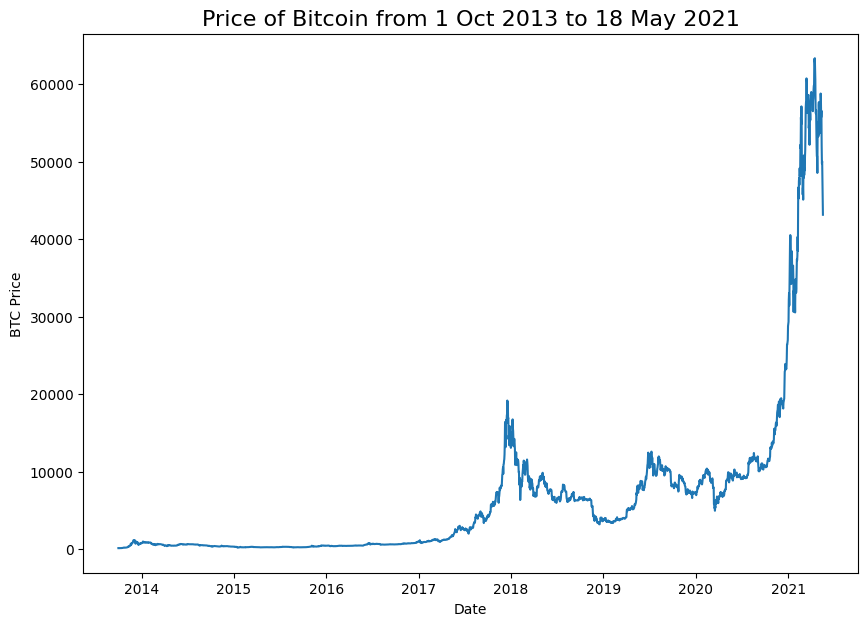

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(time_steps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

###creat a plotting function

In [6]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # plt.figure(figsize=(10, 7))
  plt.plot(timesteps[start:end], values[start:end],format, label=label)
  plt.xlabel("Date")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  
  plt.grid(True)

###Formating Data part1:Create train/test data:

In [7]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

####1- wrong way

using sklearn split is wrong with timeseries data, because we want the test data to simulate the future, to be able to simulate the real situation (predicting the next day's prices given past week), and sklearn split data randomly.
we need the train data to represnent the past and test data for pseudo-future

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size =0.2,
                                                    random_state=42)

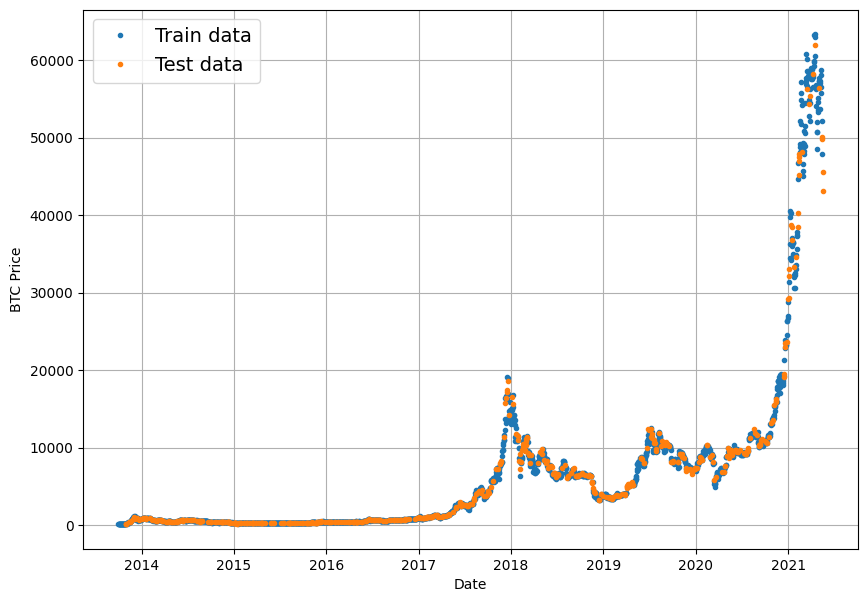

In [9]:
# # Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
# plt.scatter(X_train, y_train, s=5, label="Train data")
# plt.scatter(X_test, y_test, s=5, label="Test data")
# plt.xlabel("Date")
# plt.ylabel("BTC Price")
# plt.legend(fontsize=14)
# plt.show();

plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")

####2- The right way

using indexing

In [10]:
split_size = int(len(timesteps)*0.8)

X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

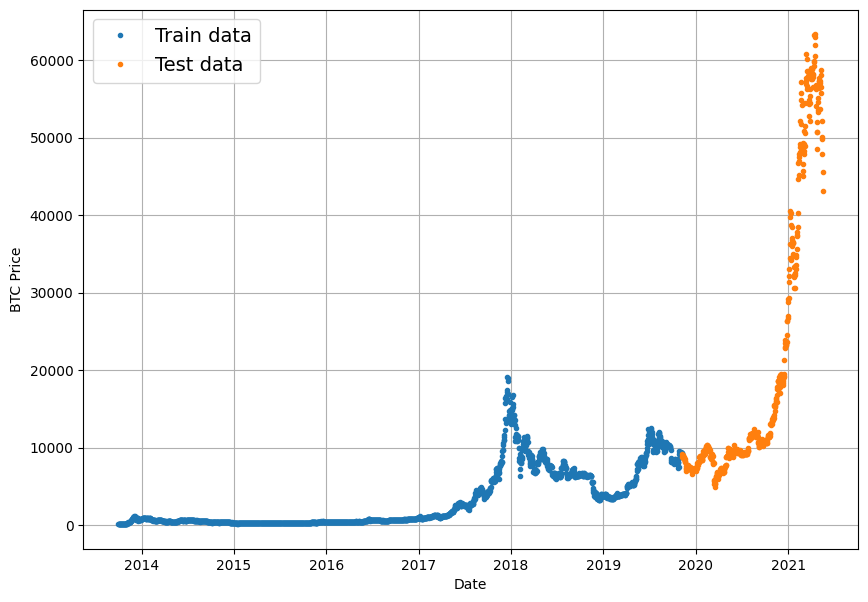

In [11]:
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")

###Modelling Experiments:

####Model0: Naïve forecast (baseline)

In [12]:
# the naïve model does is use the previous timestep value to predict the next timestep value.
# i.e. The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep)
naive_forcast = y_test[:-1]

naive_forcast[:10], naive_forcast[-10:] 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

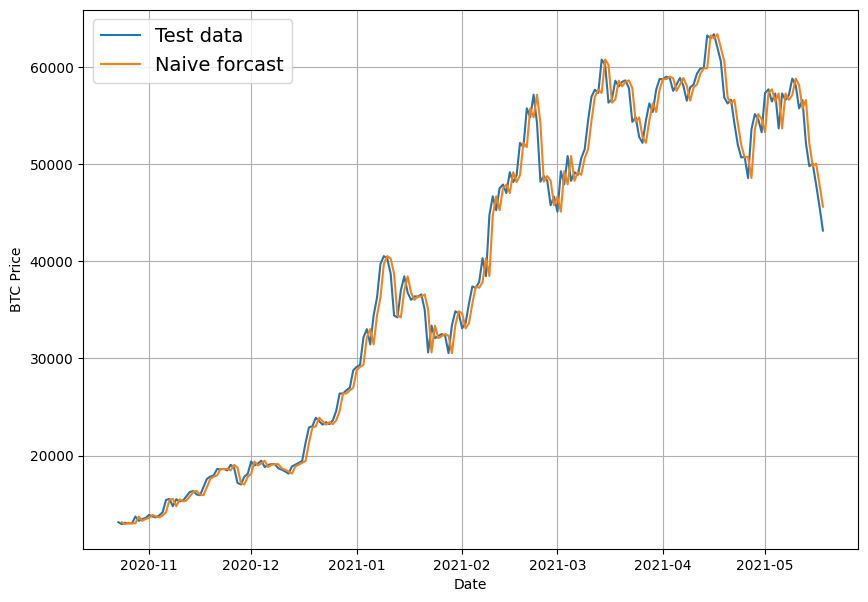

In [13]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train,values=y_train,format="-",label="Train data")
plot_time_series(timesteps=X_test,values=y_test,start = 350,format="-",label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forcast,start = 350,format="-",label="Naive forcast")

####Time series evaluation metrics:

* MAE: Mean Absolute Error
* MSE : Mean Square Error
* RMSE: Root Mean Square Error
* MAPE: Mean Absolute Percentage Error
* MASE: Mean Absolute Scaled Error ( we will used the non-seasonal version)

#####Implementing MASE:

In [14]:
# with tensorflow:
# TensorFlow doesn't have a ready-made version of MASE (mean aboslute scaled error)

import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # mae_no_season is the mae for the naive forcast 
  mae_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae/mae_no_season

In [15]:
mean_absolute_scaled_error(y_test[1:], naive_forcast).numpy()

0.9995699939182624

In [16]:
# !pip install sktime

In [17]:
# with sktime's (Scikit-Learn for time series) MeanAbsoluteScaledError class
# from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

# mean_absolute_scaled_error(y_test[1:], naive_forcast, y_train=y_train)

In [18]:
# creating a function to evaluate a model with various metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [19]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forcast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

###Formatting Data part2: Windowing Data sets

converting data into windows(i.e. Data) with their corresponding horizons (i.e. labels) [ we want to use windows of the past to predict the future ] to turn our time series problem to a supervised learning problem.


In [20]:
WINDOW_SIZE = 7 # for the last week
HORIZON = 1 # to predict the next day (8_th day)

In [21]:
# creating a function to take in an array and turn it into a window and horizon
def get_labelled_window(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  # split = len(x)-horizon
  # return (x[:split], x[split : len(x)])
  return x[:, :-horizon], x[:, -horizon:]

In [22]:
x = tf.expand_dims(tf.range(8), axis=0)

get_labelled_window(x, HORIZON)

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2.  Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
 ```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon


In [23]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):

  # 1- creat a window step -> ex:[[1,2,3,4,5,6,7]]
  window_step= np.expand_dims(np.arange(window_size + horizon),axis=0)
  print(f"window_step : {window_step}")
  # 2- create a 2D array of multiple window steps
  window_indicies = window_step + np.expand_dims(np.arange(len(x)-(window_size + horizon - 1)) ,axis=0).T
  print(f"window_indicies : {window_indicies}")
  # 3- use the window_indicies to index on the target x
  windowed_array = x[window_indicies]
  print(f"Windowed array: {windowed_array}")
  # 4- convert data to windows and labels
  windows, labels = get_labelled_window(windowed_array, horizon= horizon)

  return windows, labels

In [24]:
prices[:10], len(prices)

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]),
 2787)

In [25]:
full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON)

window_step : [[0 1 2 3 4 5 6 7]]
window_indicies : [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]
Windowed array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [26]:
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
for i in range(3):
  print(f"Window -> {full_windows[i]} , Label -> {full_labels[i]}")

Window -> [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] , Label -> [123.033]
Window -> [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] , Label -> [124.049]
Window -> [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] , Label -> [125.96116]


####Creating train/test sets from windowed data

In [28]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows)*(1-test_split))

  X_train, y_train = windows[:split_size], labels[:split_size]
  X_test, y_test = windows[split_size:], labels[split_size:]

  return X_train, X_test, y_train, y_test

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels,
                                                                                test_split=0.2)

In [30]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2224, 556, 2224, 556)

In [31]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

###Make a modelling checkpoint

to save the best performing result of a model during fitting.

In [32]:
import os
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                          save_best_only= True,
                                          verbose=0)

###Model1: Dense model

the model_1 will be a dense model with:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_1.fit(x= train_windows,
            y= train_labels,
            epochs = 100,
            batch_size= 128,
            validation_data = (test_windows, test_labels),
            callbacks =[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 3396.2939 - mae: 3396.2939 - mse: 28818222.0000  

18/18 [==============================] - 10s 96ms/step - loss: 2800.4910 - mae: 2800.4910 - mse: 21207260.0000 - val_loss: 5616.9932 - val_mae: 5616.9932 - val_mse: 57259756.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 432.4922 - mae: 432.4922 - mse: 627260.4375

18/18 [==============================] - 1s 75ms/step - loss: 412.1258 - mae: 412.1258 - mse: 586954.5625 - val_loss: 975.1678 - val_mae: 975.1678 - val_mse: 3046632.0000
Epoch 3/100
 9/18 [==============>...............] - ETA: 0s - loss: 244.7585 - mae: 244.7585 - mse: 255603.6719

18/18 [==============================] - 1s 68ms/step - loss: 219.3441 - mae: 219.3441 - mse: 217789.2031 - val_loss: 962.1776 - val_mae: 962.1776 - val_mse: 3150062.5000
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 176.9996 - mae: 176.9996 - mse: 164443.0312

18/18 [==============================] - 1s 56ms/step - loss: 174.7516 - mae: 174.7516 - mse: 157093.8594 - val_loss: 911.6886 - val_mae: 911.6886 - val_mse: 2845236.5000
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 172.5985 - mae: 172.5985 - mse: 158396.0469

18/18 [==============================] - 1s 67ms/step - loss: 162.4252 - mae: 162.4252 - mse: 141302.8438 - val_loss: 903.1750 - val_mae: 903.1750 - val_mse: 2520554.2500
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 151.9520 - mae: 151.9520 - mse: 115602.3984

18/18 [==============================] - 1s 81ms/step - loss: 153.9270 - mae: 153.9270 - mse: 127408.1562 - val_loss: 854.0059 - val_mae: 854.0059 - val_mse: 2473652.7500
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 154.3983 - mae: 154.3983 - mse: 131054.8203

18/18 [==============================] - 1s 55ms/step - loss: 148.3937 - mae: 148.3937 - mse: 119752.9766 - val_loss: 829.2909 - val_mae: 829.2909 - val_mse: 2234221.7500
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 143.6452 - mae: 143.6452 - mse: 116155.1641

18/18 [==============================] - 3s 168ms/step - loss: 143.7498 - mae: 143.7498 - mse: 115299.7344 - val_loss: 790.6395 - val_mae: 790.6395 - val_mse: 2136130.7500
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 142.8578 - mae: 142.8578 - mse: 113739.2422 - val_loss: 811.2197 - val_mae: 811.2197 - val_mse: 2090103.7500
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 136.2934 - mae: 136.2934 - mse: 98371.5078 

18/18 [==============================] - 1s 65ms/step - loss: 139.6590 - mae: 139.6590 - mse: 109837.4219 - val_loss: 758.7083 - val_mae: 758.7083 - val_mse: 1955335.8750
Epoch 11/100
13/18 [====================>.........] - ETA: 0s - loss: 140.2222 - mae: 140.2222 - mse: 113337.8672

18/18 [==============================] - 1s 54ms/step - loss: 135.4636 - mae: 135.4636 - mse: 103741.5078 - val_loss: 751.6675 - val_mae: 751.6675 - val_mse: 1874760.8750
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 132.7480 - mae: 132.7480 - mse: 100234.3984 - val_loss: 786.7571 - val_mae: 786.7571 - val_mse: 1916409.2500
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 133.1217 - mae: 133.1217 - mse: 100157.0703 - val_loss: 763.2513 - val_mae: 763.2513 - val_mse: 1830220.2500
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 127.3587 - mae: 127.3587 - mse: 94338.2891

18/18 [==============================] - 1s 64ms/step - loss: 128.9098 - mae: 128.9098 - mse: 95236.2734 - val_loss: 741.0750 - val_mae: 741.0750 - val_mse: 1749991.3750
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 125.9646 - mae: 125.9646 - mse: 90562.4375

18/18 [==============================] - 1s 69ms/step - loss: 129.2953 - mae: 129.2953 - mse: 94385.0703 - val_loss: 699.4113 - val_mae: 699.4113 - val_mse: 1634351.8750
Epoch 16/100
18/18 [==============================] - 0s 8ms/step - loss: 125.5654 - mae: 125.5654 - mse: 89221.8438 - val_loss: 711.8319 - val_mae: 711.8319 - val_mse: 1635279.6250
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 123.5023 - mae: 123.5023 - mse: 88893.0703 - val_loss: 722.4205 - val_mae: 722.4205 - val_mse: 1648248.1250
Epoch 18/100
12/18 [===================>..........] - ETA: 0s - loss: 127.6307 - mae: 127.6307 - mse: 93313.9375 

18/18 [==============================] - 1s 63ms/step - loss: 122.8774 - mae: 122.8774 - mse: 88269.7969 - val_loss: 670.9861 - val_mae: 670.9861 - val_mse: 1518726.2500
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 121.2727 - mae: 121.2727 - mse: 86791.5859 - val_loss: 688.1958 - val_mae: 688.1958 - val_mse: 1540723.0000
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 133.1036 - mae: 133.1036 - mse: 111034.4844

18/18 [==============================] - 1s 32ms/step - loss: 119.7197 - mae: 119.7197 - mse: 85511.2812 - val_loss: 662.2072 - val_mae: 662.2072 - val_mse: 1473685.2500
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 121.6030 - mae: 121.6030 - mse: 86315.6797

18/18 [==============================] - 1s 33ms/step - loss: 121.6030 - mae: 121.6030 - mse: 86315.6797 - val_loss: 647.8907 - val_mae: 647.8907 - val_mse: 1439746.1250
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5381 - mae: 118.5381 - mse: 83855.6953 - val_loss: 649.7853 - val_mae: 649.7853 - val_mse: 1430624.8750
Epoch 23/100
18/18 [==============================] - ETA: 0s - loss: 119.3123 - mae: 119.3123 - mse: 83109.8203

18/18 [==============================] - 1s 34ms/step - loss: 119.3123 - mae: 119.3123 - mse: 83109.8203 - val_loss: 637.7595 - val_mae: 637.7595 - val_mse: 1404095.3750
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 117.9095 - mae: 117.9095 - mse: 83325.7266 - val_loss: 638.2679 - val_mae: 638.2679 - val_mse: 1420924.3750
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 119.6045 - mae: 119.6045 - mse: 80372.9219

18/18 [==============================] - 1s 44ms/step - loss: 117.4665 - mae: 117.4665 - mse: 80791.5469 - val_loss: 633.6715 - val_mae: 633.6715 - val_mse: 1403157.3750
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 114.7034 - mae: 114.7034 - mse: 69110.2188

18/18 [==============================] - 1s 46ms/step - loss: 117.7715 - mae: 117.7715 - mse: 81125.5000 - val_loss: 623.4031 - val_mae: 623.4031 - val_mse: 1365083.1250
Epoch 27/100
18/18 [==============================] - 0s 12ms/step - loss: 117.4096 - mae: 117.4096 - mse: 80321.0469 - val_loss: 632.7487 - val_mae: 632.7487 - val_mse: 1396950.8750
Epoch 28/100
13/18 [====================>.........] - ETA: 0s - loss: 115.7370 - mae: 115.7370 - mse: 76399.1562

18/18 [==============================] - 1s 52ms/step - loss: 115.7129 - mae: 115.7129 - mse: 79270.3203 - val_loss: 618.2404 - val_mae: 618.2404 - val_mse: 1338612.7500
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 113.7537 - mae: 113.7537 - mse: 78485.2109 - val_loss: 636.1437 - val_mae: 636.1437 - val_mse: 1365085.2500
Epoch 30/100
14/18 [======================>.......] - ETA: 0s - loss: 118.9985 - mae: 118.9985 - mse: 79932.4453

18/18 [==============================] - 1s 47ms/step - loss: 118.7136 - mae: 118.7136 - mse: 81069.3359 - val_loss: 612.2701 - val_mae: 612.2701 - val_mse: 1318693.7500
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 118.5960 - mae: 118.5960 - mse: 78550.0000 - val_loss: 710.5886 - val_mae: 710.5886 - val_mse: 1533140.6250
Epoch 32/100
10/18 [===============>..............] - ETA: 0s - loss: 123.8461 - mae: 123.8461 - mse: 84248.2969

18/18 [==============================] - 1s 41ms/step - loss: 118.8506 - mae: 118.8506 - mse: 83147.6406 - val_loss: 607.3168 - val_mae: 607.3168 - val_mse: 1305513.6250
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 117.1736 - mae: 117.1736 - mse: 79328.3438 - val_loss: 624.0422 - val_mae: 624.0422 - val_mse: 1356402.8750
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 117.2540 - mae: 117.2540 - mse: 80302.9297 - val_loss: 617.5569 - val_mae: 617.5569 - val_mse: 1312233.0000
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 116.5790 - mae: 116.5790 - mse: 80149.7500 - val_loss: 612.7376 - val_mae: 612.7376 - val_mse: 1300472.1250
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 119.0124 - mae: 119.0124 - mse: 78615.8906 - val_loss: 607.3669 - val_mae: 607.3669 - val_mse: 1288593.7500
Epoch 37/100
18/18 [==============================] - ETA: 0s - loss: 114.8486 - mae: 114.8486 - mse: 

18/18 [==============================] - 1s 47ms/step - loss: 114.8486 - mae: 114.8486 - mse: 79034.4453 - val_loss: 605.5251 - val_mae: 605.5251 - val_mse: 1299738.8750
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 101.6560 - mae: 101.6560 - mse: 69419.1797

18/18 [==============================] - 1s 32ms/step - loss: 112.8669 - mae: 112.8669 - mse: 76770.5781 - val_loss: 598.1737 - val_mae: 598.1737 - val_mse: 1279002.5000
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2317 - mae: 113.2317 - mse: 76039.5000 - val_loss: 609.2824 - val_mae: 609.2824 - val_mse: 1305928.2500
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 103.5606 - mae: 103.5606 - mse: 104274.5391

18/18 [==============================] - 1s 31ms/step - loss: 111.3270 - mae: 111.3270 - mse: 75635.6953 - val_loss: 593.6401 - val_mae: 593.6401 - val_mse: 1261646.1250
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9455 - mae: 112.9455 - mse: 75806.7969 - val_loss: 664.5845 - val_mae: 664.5845 - val_mse: 1442760.6250
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0355 - mae: 118.0355 - mse: 79840.6719 - val_loss: 595.6086 - val_mae: 595.6086 - val_mse: 1255883.2500
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9048 - mae: 112.9048 - mse: 74424.7266 - val_loss: 629.7394 - val_mae: 629.7394 - val_mse: 1347677.7500
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3938 - mae: 113.3938 - mse: 75605.0703 - val_loss: 594.2042 - val_mae: 594.2042 - val_mse: 1261509.2500
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6399 - mae: 111.6399 - m

18/18 [==============================] - 1s 32ms/step - loss: 113.0142 - mae: 113.0142 - mse: 75523.2109 - val_loss: 587.3550 - val_mae: 587.3550 - val_mse: 1241488.3750
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4212 - mae: 113.4212 - mse: 76670.9844 - val_loss: 728.3785 - val_mae: 728.3785 - val_mse: 1557418.1250
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6265 - mae: 114.6265 - mse: 75483.0469 - val_loss: 671.1190 - val_mae: 671.1190 - val_mse: 1403689.0000
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 121.1131 - mae: 121.1131 - mse: 78335.2422 - val_loss: 588.9971 - val_mae: 588.9971 - val_mse: 1243461.0000
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 111.5322 - mae: 111.5322 - mse: 75755.0938 - val_loss: 667.2881 - val_mae: 667.2881 - val_mse: 1431856.7500
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3626 - mae: 112.3626 - m

18/18 [==============================] - 1s 31ms/step - loss: 111.6974 - mae: 111.6974 - mse: 75210.5703 - val_loss: 579.7667 - val_mae: 579.7667 - val_mse: 1215928.6250
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9782 - mae: 108.9782 - mse: 72841.8984 - val_loss: 767.7572 - val_mae: 767.7572 - val_mse: 1741468.5000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 126.5297 - mae: 126.5297 - mse: 85298.3438 - val_loss: 735.9944 - val_mae: 735.9944 - val_mse: 1635240.8750
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 119.0166 - mae: 119.0166 - mse: 77691.4141 - val_loss: 641.9805 - val_mae: 641.9805 - val_mse: 1357962.6250
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 110.4391 - mae: 110.4391 - mse: 72977.1094

18/18 [==============================] - 1s 33ms/step - loss: 110.4391 - mae: 110.4391 - mse: 72977.1094 - val_loss: 579.7564 - val_mae: 579.7564 - val_mse: 1217739.1250
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1591 - mae: 109.1591 - mse: 72939.8828 - val_loss: 599.8785 - val_mae: 599.8785 - val_mse: 1242148.1250
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 132.9145 - mae: 132.9145 - mse: 97084.4688

18/18 [==============================] - 1s 32ms/step - loss: 109.1875 - mae: 109.1875 - mse: 73104.6562 - val_loss: 579.1437 - val_mae: 579.1437 - val_mse: 1208873.8750
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 108.2974 - mae: 108.2974 - mse: 71925.5938 - val_loss: 579.3918 - val_mae: 579.3918 - val_mse: 1214885.5000
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0903 - mae: 110.0903 - mse: 73087.2578 - val_loss: 625.0042 - val_mae: 625.0042 - val_mse: 1290772.1250
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4140 - mae: 110.4140 - mse: 73194.8281 - val_loss: 595.5367 - val_mae: 595.5367 - val_mse: 1231401.5000
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 110.1279 - mae: 110.1279 - mse: 73013.6641 

18/18 [==============================] - 1s 33ms/step - loss: 110.1279 - mae: 110.1279 - mse: 73013.6641 - val_loss: 575.0255 - val_mae: 575.0255 - val_mse: 1200521.5000
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3206 - mae: 110.3206 - mse: 72565.6094 - val_loss: 575.4225 - val_mae: 575.4225 - val_mse: 1197618.8750
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3727 - mae: 108.3727 - mse: 71414.6094 - val_loss: 675.9280 - val_mae: 675.9280 - val_mse: 1442946.2500
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7832 - mae: 113.7832 - mse: 71622.5703 - val_loss: 690.1351 - val_mae: 690.1351 - val_mse: 1483310.2500
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 124.5634 - mae: 124.5634 - mse: 81820.5859 - val_loss: 609.3699 - val_mae: 609.3699 - val_mse: 1270708.5000
Epoch 70/100
16/18 [=========================>....] - ETA: 0s - loss: 129.6603 - mae: 129.6603 - mse: 

18/18 [==============================] - 1s 35ms/step - loss: 130.1895 - mae: 130.1895 - mse: 87409.2031 - val_loss: 574.2764 - val_mae: 574.2764 - val_mse: 1197374.6250
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7945 - mae: 113.7945 - mse: 74577.4844 - val_loss: 592.2644 - val_mae: 592.2644 - val_mse: 1219960.1250
Epoch 72/100
15/18 [========================>.....] - ETA: 0s - loss: 107.7152 - mae: 107.7152 - mse: 71903.0938

18/18 [==============================] - 1s 31ms/step - loss: 109.1971 - mae: 109.1971 - mse: 72579.7422 - val_loss: 573.0188 - val_mae: 573.0188 - val_mse: 1191125.5000
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2290 - mae: 111.2290 - mse: 73105.7266 - val_loss: 610.9465 - val_mae: 610.9465 - val_mse: 1271575.7500
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 171.6144 - mae: 171.6144 - mse: 177485.3125

18/18 [==============================] - 1s 32ms/step - loss: 108.3909 - mae: 108.3909 - mse: 72198.6875 - val_loss: 572.3725 - val_mae: 572.3725 - val_mse: 1188256.5000
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9027 - mae: 108.9027 - mse: 71686.7812 - val_loss: 572.7106 - val_mae: 572.7106 - val_mse: 1190310.0000
Epoch 76/100
14/18 [======================>.......] - ETA: 0s - loss: 110.6396 - mae: 110.6396 - mse: 71297.4141

18/18 [==============================] - 1s 46ms/step - loss: 109.5804 - mae: 109.5804 - mse: 72551.7891 - val_loss: 571.9144 - val_mae: 571.9144 - val_mse: 1182801.2500
Epoch 77/100
12/18 [===================>..........] - ETA: 0s - loss: 111.2585 - mae: 111.2585 - mse: 73513.5078

18/18 [==============================] - 2s 101ms/step - loss: 107.9091 - mae: 107.9091 - mse: 70844.3203 - val_loss: 571.8887 - val_mae: 571.8887 - val_mse: 1185018.2500
Epoch 78/100
18/18 [==============================] - 0s 12ms/step - loss: 109.1216 - mae: 109.1216 - mse: 70687.7344 - val_loss: 584.9836 - val_mae: 584.9836 - val_mse: 1214524.1250
Epoch 79/100
18/18 [==============================] - 0s 12ms/step - loss: 109.2474 - mae: 109.2474 - mse: 73667.7188 - val_loss: 587.6697 - val_mae: 587.6697 - val_mse: 1219024.7500
Epoch 80/100
18/18 [==============================] - 0s 10ms/step - loss: 107.5165 - mae: 107.5165 - mse: 71788.9375 - val_loss: 600.0942 - val_mae: 600.0942 - val_mse: 1229238.1250
Epoch 81/100
12/18 [===================>..........] - ETA: 0s - loss: 107.4357 - mae: 107.4357 - mse: 72730.6641

18/18 [==============================] - 1s 61ms/step - loss: 107.7004 - mae: 107.7004 - mse: 71633.6797 - val_loss: 571.0025 - val_mae: 571.0025 - val_mse: 1183379.1250
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 119.0312 - mae: 119.0312 - mse: 85567.0469 

18/18 [==============================] - 1s 87ms/step - loss: 116.6870 - mae: 116.6870 - mse: 78078.0859 - val_loss: 570.4144 - val_mae: 570.4144 - val_mse: 1181147.3750
Epoch 83/100
18/18 [==============================] - 0s 17ms/step - loss: 113.9442 - mae: 113.9442 - mse: 75471.1484 - val_loss: 669.8527 - val_mae: 669.8527 - val_mse: 1413091.8750
Epoch 84/100
18/18 [==============================] - 0s 14ms/step - loss: 113.6342 - mae: 113.6342 - mse: 73698.5625 - val_loss: 591.2361 - val_mae: 591.2361 - val_mse: 1223231.0000
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 108.0817 - mae: 108.0817 - mse: 71672.1328 - val_loss: 595.5635 - val_mae: 595.5635 - val_mse: 1218717.0000
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 108.2386 - mae: 108.2386 - mse: 70536.9531 - val_loss: 573.7195 - val_mae: 573.7195 - val_mse: 1179830.2500
Epoch 87/100
18/18 [==============================] - 0s 12ms/step - loss: 106.4032 - mae: 106.4032

18/18 [==============================] - 1s 72ms/step - loss: 108.2164 - mae: 108.2164 - mse: 70377.8594 - val_loss: 568.3037 - val_mae: 568.3037 - val_mse: 1174212.2500
Epoch 90/100
18/18 [==============================] - 0s 12ms/step - loss: 106.4975 - mae: 106.4975 - mse: 68740.7344 - val_loss: 586.9945 - val_mae: 586.9945 - val_mse: 1201892.3750
Epoch 91/100
18/18 [==============================] - 0s 15ms/step - loss: 111.8160 - mae: 111.8160 - mse: 73529.1484 - val_loss: 629.2352 - val_mae: 629.2352 - val_mse: 1305212.3750
Epoch 92/100
18/18 [==============================] - 0s 14ms/step - loss: 109.7094 - mae: 109.7094 - mse: 72530.3672 - val_loss: 583.8498 - val_mae: 583.8498 - val_mse: 1207849.1250
Epoch 93/100
18/18 [==============================] - 0s 15ms/step - loss: 117.1478 - mae: 117.1478 - mse: 76547.9922 - val_loss: 645.2401 - val_mae: 645.2401 - val_mse: 1344057.2500
Epoch 94/100
18/18 [==============================] - 0s 12ms/step - loss: 113.3918 - mae: 113.391

18/18 [==============================] - 1s 63ms/step - loss: 107.7980 - mae: 107.7980 - mse: 71691.0156 - val_loss: 568.2535 - val_mae: 568.2535 - val_mse: 1170868.5000
Epoch 99/100
18/18 [==============================] - 0s 10ms/step - loss: 109.3287 - mae: 109.3287 - mse: 71857.8984 - val_loss: 568.3317 - val_mae: 568.3317 - val_mse: 1169407.7500
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 113.5498 - mae: 113.5498 - mse: 71948.7891 - val_loss: 649.4801 - val_mae: 649.4801 - val_mse: 1333191.0000


In [34]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 649.4801 - mae: 649.4801 - mse: 1333191.6250


[649.4801025390625, 649.4801025390625, 1333191.625]

In [35]:
# use the cop that saved by checkmodel
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")

In [36]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.2534 - mae: 568.2534 - mse: 1170868.2500


[568.25341796875, 568.25341796875, 1170868.25]

####Creating function to make predictions

In [37]:
def make_preds(model, input_data):
  forcast = model.predict(input_data)

  return tf.squeeze(forcast)

In [38]:
model_1_preds = make_preds(model_1,test_windows)

18/18 [==============================] - 0s 2ms/step


In [39]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8869.301, 8778.102, 9032.354, 8795.888, 8738.333, 8749.499,
       8683.041, 8523.996, 8468.725, 8527.103], dtype=float32)>

In [40]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [41]:
squeezed_test_labels = tf.squeeze(test_labels)

In [42]:
model_1_results = evaluate_preds(y_true= squeezed_test_labels,
                                 y_pred= model_1_preds)

model_1_results

{'mae': 568.25336,
 'mse': 1170868.2,
 'rmse': 1082.0667,
 'mape': 2.5423863,
 'mase': 0.9982638}

####Visualize model_1 predictions

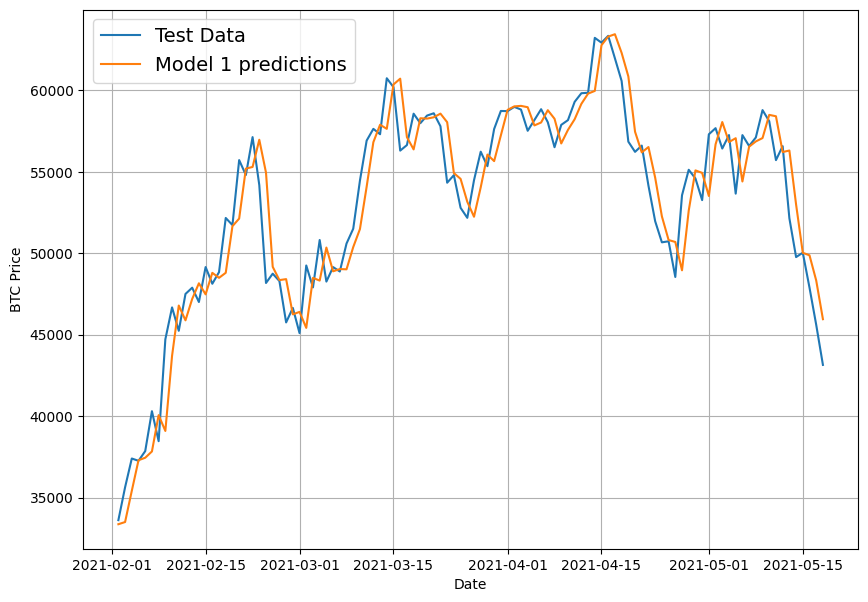

In [43]:
offset = 450

plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= test_labels[:,0],
                 start= offset,
                 format='-',
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= model_1_preds,
                 start= offset,
                 format='-',
                 label="Model 1 predictions")

###Model2: same as model_1 with different window_size

window_size=30 , horizon=1

In [44]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window_step : [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
window_indicies : [[   0    1    2 ...   28   29   30]
 [   1    2    3 ...   29   30   31]
 [   2    3    4 ...   30   31   32]
 ...
 [2754 2755 2756 ... 2782 2783 2784]
 [2755 2756 2757 ... 2783 2784 2785]
 [2756 2757 2758 ... 2784 2785 2786]]
Windowed array: [[  123.65499      125.455        108.58483    ...   192.75666
    197.4          196.02499   ]
 [  125.455        108.58483      118.67466    ...   197.4
    196.02499      198.04883   ]
 [  108.58483      118.67466      121.33866    ...   196.02499
    198.04883      198.93233   ]
 ...
 [63346.78903511 61965.7825981  60574.44472823 ... 49764.1320816
  50032.69313676 47885.62525472]
 [61965.7825981  60574.44472823 56850.83016569 ... 50032.69313676
  47885.62525472 45604.61575361]
 [60574.44472823 56850.83016569 56224.10158771 ... 47885.62525472
  45604.61575361 43144.47129086]]


(2757, 2757)

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 649.7660


649.7659912109375

In [48]:
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")

In [49]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 613.6771


613.6770629882812

In [50]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)
# model_2_preds

18/18 [==============================] - 0s 2ms/step


In [51]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 613.67706,
 'mse': 1284718.2,
 'rmse': 1133.4541,
 'mape': 2.7941198,
 'mase': 1.0727135}

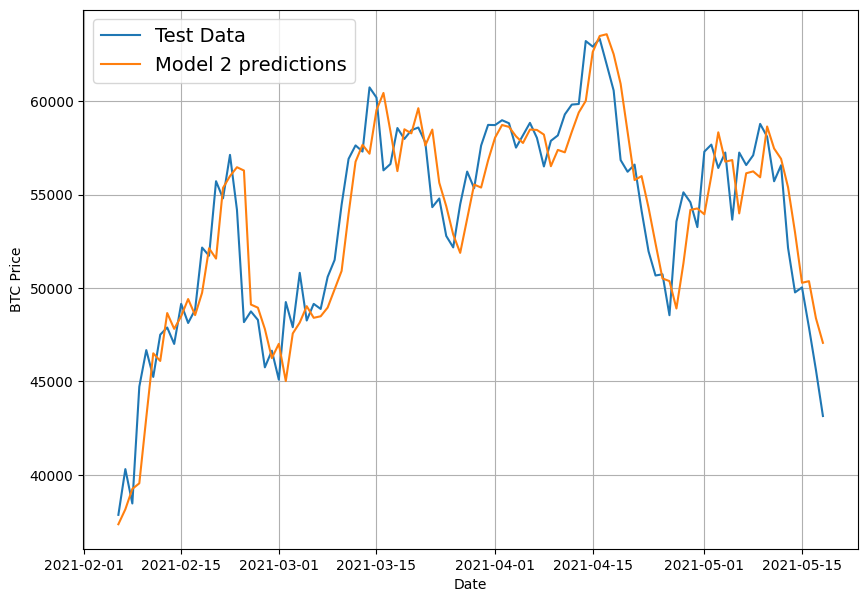

In [52]:
offset = 450

plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= test_labels[:,0],
                 start= offset,
                 format='-',
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= model_2_preds,
                 start= offset,
                 format='-',
                 label="Model 2 predictions")

###Model 3: Dense (window = 30, horizon = 7)

In [53]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels,
                                                                                test_split=0.2)


window_step : [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
window_indicies : [[   0    1    2 ...   34   35   36]
 [   1    2    3 ...   35   36   37]
 [   2    3    4 ...   36   37   38]
 ...
 [2748 2749 2750 ... 2782 2783 2784]
 [2749 2750 2751 ... 2783 2784 2785]
 [2750 2751 2752 ... 2784 2785 2786]]
Windowed array: [[  123.65499      125.455        108.58483    ...   210.3075
    225.02         248.25333   ]
 [  125.455        108.58483      118.67466    ...   225.02
    248.25333      262.32666   ]
 [  108.58483      118.67466      121.33866    ...   248.25333
    262.32666      294.48699   ]
 ...
 [58171.9090187  59295.95004401 59822.90167743 ... 49764.1320816
  50032.69313676 47885.62525472]
 [59295.95004401 59822.90167743 59853.19724227 ... 50032.69313676
  47885.62525472 45604.61575361]
 [59822.90167743 59853.19724227 63223.88439079 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [54]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1430.7891


1430.7890625

In [56]:
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense")

model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1238.0005


1238.00048828125

In [57]:
model_3_preds = make_preds(model_3, test_windows)

model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds)
model_3_results

18/18 [==============================] - 0s 2ms/step


{'mae': 1238.0006,
 'mse': 5511993.0,
 'rmse': 1421.4152,
 'mape': 5.541824,
 'mase': 2.2029526}

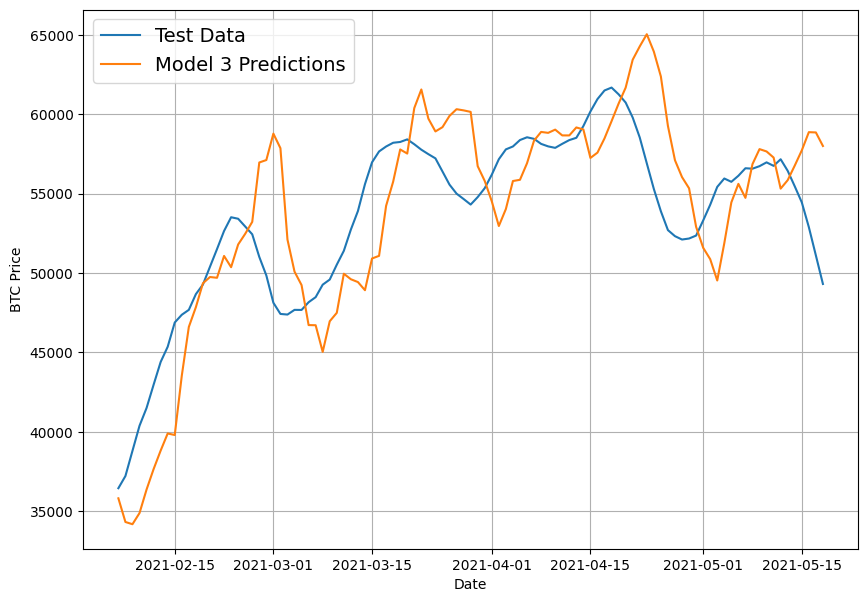

In [58]:
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(test_labels,axis=1),
                 format="-",
                 start = offset,
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds,axis=1),
                 format="-",
                 start = offset,
                 label="Model 3 Predictions")

In [59]:
model_3_preds.shape

TensorShape([551, 7])

In [60]:
tf.reduce_mean(model_3_preds,axis=1).shape

TensorShape([551])

In [61]:
test_labels.shape

(551, 7)

###Compare first 3 models:

<Axes: >

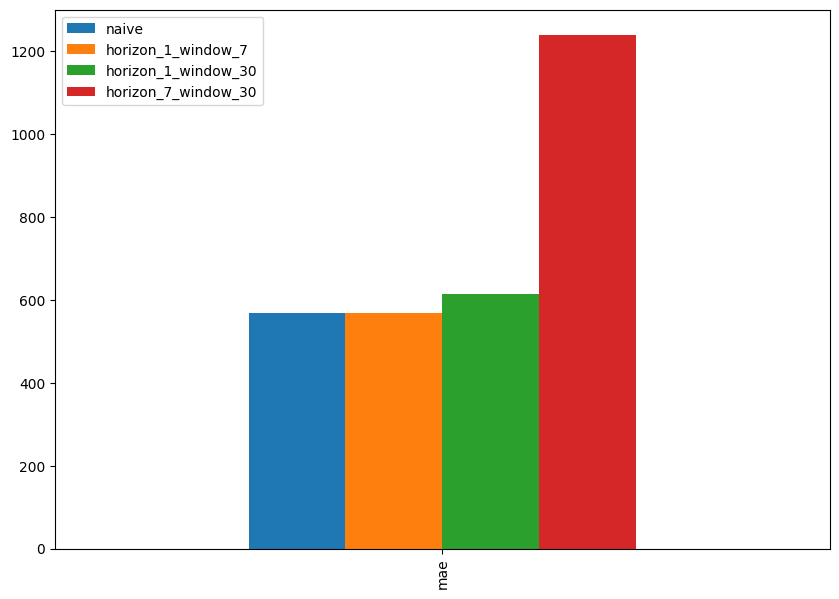

In [62]:
pd.DataFrame({"naive":naive_results,
                               "horizon_1_window_7":model_1_results,
                               "horizon_1_window_30":model_2_results,
                               "horizon_7_window_30":model_3_results}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

# compare_results

###Model 4: Conv1D

In [63]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels,
                                                                                test_split=0.2)

window_step : [[0 1 2 3 4 5 6 7]]
window_indicies : [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]
Windowed array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [64]:
train_windows.shape

(2224, 7)

In [65]:
l = tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=2))
l(train_windows).shape

TensorShape([2224, 7, 1])

In [66]:
# Conv1D requires the input to be in shape:(batch_size, timesteps, input_dim),
# so we will adjust our data to be in the required input shape
# To Do so we will use the "Lambda Layer" to make the model do the teshaping process for us
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x:tf.expand_dims(x, axis=1)),
    layers.Conv1D(128,  kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer= tf.keras.optimizers.Adam())

model_4.fit(x= train_windows,
            y= train_labels,
            validation_data=(test_windows, test_labels),
            epochs= 100,
            batch_size= 128,
            verbose=1,
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2651.4407  

18/18 [==============================] - 7s 55ms/step - loss: 2616.0503 - val_loss: 5907.9297
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 405.5638

18/18 [==============================] - 1s 41ms/step - loss: 401.3134 - val_loss: 1247.1066
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 233.1217

18/18 [==============================] - 1s 41ms/step - loss: 231.7770 - val_loss: 1210.7324
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 218.1881

18/18 [==============================] - 1s 41ms/step - loss: 217.2093 - val_loss: 1165.3887
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 209.5332

18/18 [==============================] - 1s 63ms/step - loss: 207.2953 - val_loss: 1144.4250
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 210.3225 - val_loss: 1147.6469
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 206.9150

18/18 [==============================] - 1s 44ms/step - loss: 206.9150 - val_loss: 1119.1801
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 197.5739

18/18 [==============================] - 1s 42ms/step - loss: 198.2254 - val_loss: 1102.5272
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 195.3035 - val_loss: 1109.2714
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 190.1516

18/18 [==============================] - 1s 42ms/step - loss: 191.5993 - val_loss: 1073.2953
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 188.6916

18/18 [==============================] - 1s 41ms/step - loss: 188.6916 - val_loss: 1049.9224
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 188.8837 - val_loss: 1059.8049
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 183.2493 - val_loss: 1074.2837
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 177.1093

18/18 [==============================] - 1s 41ms/step - loss: 179.1542 - val_loss: 1030.4558
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 177.3321

18/18 [==============================] - 1s 42ms/step - loss: 177.1442 - val_loss: 1000.5188
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 174.1301

18/18 [==============================] - 1s 43ms/step - loss: 172.4343 - val_loss: 971.7731
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 169.8765 - val_loss: 996.6605
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 167.8280 - val_loss: 1002.2361
Epoch 19/100
11/18 [=================>............] - ETA: 0s - loss: 172.6680

18/18 [==============================] - 1s 60ms/step - loss: 164.6823 - val_loss: 923.9247
Epoch 20/100
12/18 [===================>..........] - ETA: 0s - loss: 162.5730

18/18 [==============================] - 1s 58ms/step - loss: 160.0536 - val_loss: 893.5117
Epoch 21/100
12/18 [===================>..........] - ETA: 0s - loss: 161.3074

18/18 [==============================] - 1s 45ms/step - loss: 157.8483 - val_loss: 878.0992
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 154.3491

18/18 [==============================] - 1s 40ms/step - loss: 154.3491 - val_loss: 874.9496
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 149.5241

18/18 [==============================] - 1s 61ms/step - loss: 150.8827 - val_loss: 865.1041
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 149.6675

18/18 [==============================] - 1s 41ms/step - loss: 149.6675 - val_loss: 846.7475
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 152.0090

18/18 [==============================] - 1s 40ms/step - loss: 145.8320 - val_loss: 819.3855
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 142.9878

18/18 [==============================] - 1s 40ms/step - loss: 143.3271 - val_loss: 791.8118
Epoch 27/100
16/18 [=========================>....] - ETA: 0s - loss: 141.7376

18/18 [==============================] - 1s 43ms/step - loss: 141.6041 - val_loss: 775.3923
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 137.1588

18/18 [==============================] - 1s 42ms/step - loss: 137.9952 - val_loss: 767.1267
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 130.8075

18/18 [==============================] - 1s 40ms/step - loss: 136.6032 - val_loss: 754.2153
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 138.8106 - val_loss: 878.6668
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 142.4184 - val_loss: 838.0638
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 134.8578 - val_loss: 765.6423
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 132.4422

18/18 [==============================] - 1s 41ms/step - loss: 131.6556 - val_loss: 737.7896
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 129.0057

18/18 [==============================] - 1s 41ms/step - loss: 129.0057 - val_loss: 709.3130
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 127.0992

18/18 [==============================] - 1s 43ms/step - loss: 127.1094 - val_loss: 706.0905
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 128.9802 - val_loss: 747.0768
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 128.7220

18/18 [==============================] - 1s 43ms/step - loss: 129.5423 - val_loss: 686.6935
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 124.8788

18/18 [==============================] - 1s 59ms/step - loss: 124.8788 - val_loss: 673.2665
Epoch 39/100
18/18 [==============================] - 0s 10ms/step - loss: 124.9229 - val_loss: 680.3053
Epoch 40/100
10/18 [===============>..............] - ETA: 0s - loss: 122.6550

18/18 [==============================] - 1s 83ms/step - loss: 122.7448 - val_loss: 663.7040
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 123.0041

18/18 [==============================] - 1s 41ms/step - loss: 123.0041 - val_loss: 657.8779
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 126.2151

18/18 [==============================] - 1s 40ms/step - loss: 126.2151 - val_loss: 651.0919
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 119.6030 - val_loss: 655.7469
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 119.7703

18/18 [==============================] - 1s 41ms/step - loss: 119.7703 - val_loss: 642.6151
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 116.8706

18/18 [==============================] - 1s 40ms/step - loss: 118.9767 - val_loss: 639.1601
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 120.4337

18/18 [==============================] - 1s 41ms/step - loss: 120.4337 - val_loss: 636.8862
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 125.4657 - val_loss: 772.4573
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 120.7995 - val_loss: 721.2679
Epoch 49/100
16/18 [=========================>....] - ETA: 0s - loss: 123.4716

18/18 [==============================] - 1s 42ms/step - loss: 124.3580 - val_loss: 625.9279
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8975 - val_loss: 626.1711
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3126 - val_loss: 626.7459
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5384 - val_loss: 629.1570
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3843 - val_loss: 643.7058
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 117.5536 - val_loss: 663.9282
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 118.3018 - val_loss: 634.1133
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4145 - val_loss: 780.7473
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 132.7619 - val_loss: 721.9006
Epoch 58/100
18/18 [==============================] - ETA: 0s - loss: 122.68

18/18 [==============================] - 1s 41ms/step - loss: 122.6866 - val_loss: 623.3305
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 114.6700

18/18 [==============================] - 1s 42ms/step - loss: 114.6700 - val_loss: 605.2523
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9082 - val_loss: 613.9967
Epoch 61/100
18/18 [==============================] - ETA: 0s - loss: 112.8729

18/18 [==============================] - 1s 42ms/step - loss: 112.8729 - val_loss: 603.8088
Epoch 62/100
17/18 [===========================>..] - ETA: 0s - loss: 111.4342

18/18 [==============================] - 1s 40ms/step - loss: 111.1990 - val_loss: 601.0163
Epoch 63/100
18/18 [==============================] - ETA: 0s - loss: 113.8145

18/18 [==============================] - 1s 40ms/step - loss: 113.8145 - val_loss: 600.0713
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1660 - val_loss: 633.3788
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 132.0080

18/18 [==============================] - 1s 71ms/step - loss: 114.7113 - val_loss: 599.9610
Epoch 66/100
13/18 [====================>.........] - ETA: 0s - loss: 110.3640

18/18 [==============================] - 1s 59ms/step - loss: 112.1118 - val_loss: 591.1821
Epoch 67/100
18/18 [==============================] - 0s 8ms/step - loss: 110.1732 - val_loss: 627.1544
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 119.1726 - val_loss: 707.7170
Epoch 69/100
18/18 [==============================] - 0s 9ms/step - loss: 127.5373 - val_loss: 686.6285
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 127.0173 - val_loss: 607.6232
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9833 - val_loss: 620.1154
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0227 - val_loss: 597.6469
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 112.6891 - val_loss: 617.0829
Epoch 74/100
17/18 [===========================>..] - ETA: 0s - loss: 110.7929

18/18 [==============================] - 1s 45ms/step - loss: 110.9022 - val_loss: 583.8275
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7303 - val_loss: 616.2099
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 112.6596 - val_loss: 597.7496
Epoch 77/100
17/18 [===========================>..] - ETA: 0s - loss: 111.7537

18/18 [==============================] - 1s 42ms/step - loss: 110.9815 - val_loss: 581.1326
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0725 - val_loss: 601.9203
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7726 - val_loss: 613.4658
Epoch 80/100
18/18 [==============================] - ETA: 0s - loss: 111.4585

18/18 [==============================] - 1s 41ms/step - loss: 111.4585 - val_loss: 580.7934
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 108.1816

18/18 [==============================] - 1s 43ms/step - loss: 108.7338 - val_loss: 579.0903
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6870 - val_loss: 579.3029
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0446 - val_loss: 684.8773
Epoch 84/100
17/18 [===========================>..] - ETA: 0s - loss: 118.4470

18/18 [==============================] - 1s 43ms/step - loss: 117.9207 - val_loss: 576.0029
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 112.7984 - val_loss: 584.5334
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 109.6345 - val_loss: 639.8275
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9301 - val_loss: 576.2866
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 109.9832 - val_loss: 593.9302
Epoch 89/100
17/18 [===========================>..] - ETA: 0s - loss: 108.6539

18/18 [==============================] - 1s 44ms/step - loss: 110.1000 - val_loss: 574.5386
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 108.7341 - val_loss: 653.0217
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2007 - val_loss: 607.2157
Epoch 92/100
16/18 [=========================>....] - ETA: 0s - loss: 109.2280

18/18 [==============================] - 1s 45ms/step - loss: 110.4343 - val_loss: 572.1259
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8436 - val_loss: 620.3810
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1691 - val_loss: 585.2203
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9075 - val_loss: 575.3439
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1309 - val_loss: 633.0474
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3178 - val_loss: 608.8870
Epoch 98/100
16/18 [=========================>....] - ETA: 0s - loss: 112.1003

18/18 [==============================] - 1s 43ms/step - loss: 110.4742 - val_loss: 571.8906
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 108.8565

18/18 [==============================] - 1s 40ms/step - loss: 108.3063 - val_loss: 570.3473
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0477 - val_loss: 621.1838


In [67]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 621.1838


621.1837768554688

In [69]:
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1D")

model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.3471


570.3471069335938

In [70]:
model_4_preds = make_preds(model_4, test_windows)

model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8885.486, 8793.131, 8988.322, 8774.243, 8752.587, 8720.082,
       8678.579, 8534.342, 8456.202, 8512.328], dtype=float32)>

In [71]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred= model_4_preds)

model_4_results

{'mae': 570.3471,
 'mse': 1178919.9,
 'rmse': 1085.7808,
 'mape': 2.5547671,
 'mase': 1.0019419}

###Model 5: RNN (LSTM)

In [72]:
# the required input shape is same as conv1D : (batch_size, timesteps, input_dim)

tf.random.set_seed(42)

input = layers.Input(shape=(WINDOW_SIZE))

x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(input)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(input, output, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer= tf.keras.optimizers.Adam())

In [73]:
model_5.fit(x= train_windows,
            y= train_labels,
            validation_data=(test_windows, test_labels),
            epochs= 100,
            batch_size= 128,
            verbose=1,
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 149ms/step - loss: 2407.1411 - val_loss: 10704.5352
Epoch 2/100
18/18 [==============================] - 2s 120ms/step - loss: 940.6032 - val_loss: 1537.5265
Epoch 3/100
18/18 [==============================] - 2s 107ms/step - loss: 251.9981 - val_loss: 1047.2500
Epoch 4/100
18/18 [==============================] - 2s 124ms/step - loss: 199.0208 - val_loss: 1036.5748
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 190.0871 - val_loss: 1087.1005
Epoch 6/100
18/18 [==============================] - 2s 105ms/step - loss: 184.6223 - val_loss: 1022.0599
Epoch 7/100
18/18 [==============================] - 2s 106ms/step - loss: 181.6451 - val_loss: 1004.8403
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 177.4025 - val_loss: 1013.8611
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 178.8293 - val_loss: 1037.2111
Epoch 10/100
18/18 [==============================

In [74]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 606.7986


606.798583984375

In [75]:
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM")

model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 597.8840


597.884033203125

In [76]:
model_5_preds = make_preds(model_5, test_windows)

model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8977.431, 8825.973, 8964.647, 8798.838, 8780.036, 8779.197,
       8696.423, 8559.687, 8507.103, 8515.864], dtype=float32)>

In [77]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred= model_5_preds)

model_5_results

{'mae': 597.88403,
 'mse': 1268127.2,
 'rmse': 1126.1116,
 'mape': 2.6869256,
 'mase': 1.0503167}

###Make a multivariate time series

In [78]:
# adding 'bit-halving (bloack rewards)' feature to our historical prices
# getting halving-dates and block_rewards from 'https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving'

block_reward_1 = 50 # 3 January 2009 (will not be included in our data)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [79]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [80]:
bitcoin_prices.index[0]

Timestamp('2013-10-01 00:00:00')

In [81]:
# to add the new data to our dataframe ranges from each date will be set to the reward of that range
# e.g. from 2013-10-01 to 2016-07-09 will set to block reward of 25
# get our indexes that we will use to add block-rewards at
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [82]:
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [83]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[: block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days : block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


In [84]:
bitcoin_prices_block.iloc[1010 :1200]

,Price,block_reward
Date,,
2016-07-07,671.81400,25
2016-07-08,640.47600,25
2016-07-09,654.85299,12.5
2016-07-10,649.35600,12.5
2016-07-11,656.74700,12.5
...,...,...
2017-01-08,923.52375,12.5
2017-01-09,889.33875,12.5
2017-01-10,905.22625,12.5


In [85]:
# to visualize our new multivariate data we need to adjust the scale
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns= bitcoin_prices_block.columns,
                                     index= bitcoin_prices_block.index)

scaled_price_block_df

,Price,block_reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0
...,...,...
2021-05-14,0.785214,0.0
2021-05-15,0.789461,0.0
2021-05-16,0.755509,0.0


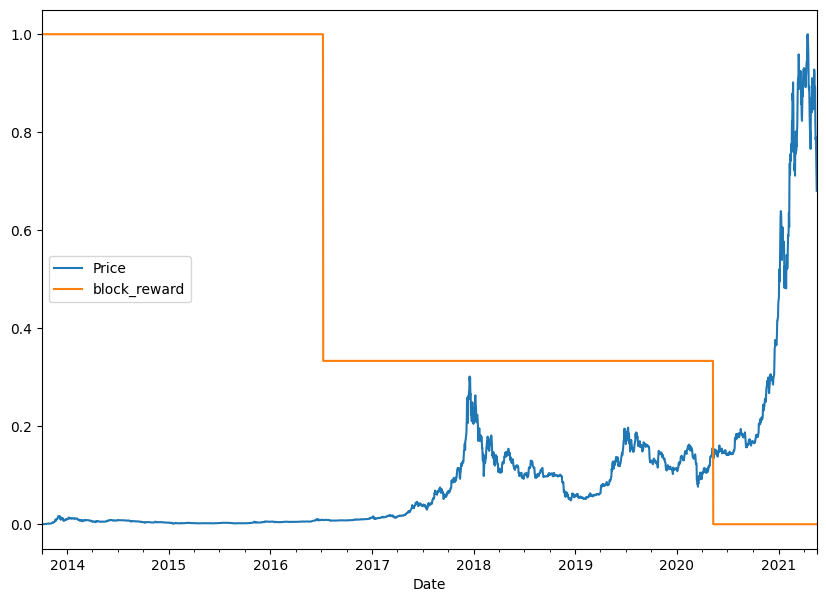

In [86]:
scaled_price_block_df.plot(figsize=(10,7));
# from the plot we notice that, as the block reward goes down, the price of bitcoin goes up.

###Preparing the Multivariate Data

####Making Windowed data using Pandas

In [87]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price + {(i+1)}"] = bitcoin_prices_windowed["Price"].shift(i)

bitcoin_prices_windowed.head(15)

,Price,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,,
2013-10-01,123.65499,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-05,121.33866,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-06,120.65533,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-07,121.79500,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-08,123.03300,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-09,124.04900,25,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483


In [88]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [89]:
X

,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-07,25.00,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-08,25.00,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-09,25.00,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-10,25.00,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-11,25.00,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661
...,...,...,...,...,...,...,...,...
2021-05-14,6.25,49764.132812,52147.820312,56573.554688,55715.546875,58102.191406,58788.210938,57107.121094
2021-05-15,6.25,50032.691406,49764.132812,52147.820312,56573.554688,55715.546875,58102.191406,58788.210938
2021-05-16,6.25,47885.625000,50032.691406,49764.132812,52147.820312,56573.554688,55715.546875,58102.191406


In [90]:
y

Date
2013-10-07      121.794998
2013-10-08      123.032997
2013-10-09      124.049004
2013-10-10      125.961159
2013-10-11      125.279663
                  ...     
2021-05-14    49764.132812
2021-05-15    50032.691406
2021-05-16    47885.625000
2021-05-17    45604.617188
2021-05-18    43144.472656
Name: Price, Length: 2781, dtype: float32

####Create train/test sets b indexing

In [91]:
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 557, 557)

###Model 6: Dense (multivariate time series)


In [92]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_6.fit(x= X_train,
            y= y_train,
            epochs = 100,
            batch_size= 128,
            validation_data = (X_test, y_test),
            callbacks =[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1701.2755 - mae: 1701.2755 - mse: 9134897.0000  

18/18 [==============================] - 2s 42ms/step - loss: 1666.9285 - mae: 1666.9285 - mse: 8938559.0000 - val_loss: 1358.2316 - val_mae: 1358.2314 - val_mse: 4923821.5000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 343.7108 - mae: 343.7108 - mse: 422117.7812 - val_loss: 1792.8162 - val_mae: 1792.8162 - val_mse: 6970030.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 237.0028 - mae: 237.0028 - mse: 174125.4219

18/18 [==============================] - 1s 31ms/step - loss: 179.3159 - mae: 179.3159 - mse: 149547.5156 - val_loss: 999.9414 - val_mae: 999.9414 - val_mse: 2590543.2500
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 136.9792 - mae: 136.9792 - mse: 96859.1797 

18/18 [==============================] - 1s 31ms/step - loss: 137.1165 - mae: 137.1165 - mse: 97301.5781 - val_loss: 727.0503 - val_mae: 727.0503 - val_mse: 1709368.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 132.9512 - mae: 132.9512 - mse: 80616.3984

18/18 [==============================] - 1s 31ms/step - loss: 126.3588 - mae: 126.3588 - mse: 86737.8438 - val_loss: 689.1564 - val_mae: 689.1564 - val_mse: 1574636.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 105.1184 - mae: 105.1184 - mse: 47802.2812

18/18 [==============================] - 1s 30ms/step - loss: 123.3914 - mae: 123.3914 - mse: 80295.3828 - val_loss: 661.0809 - val_mae: 661.0809 - val_mse: 1462711.3750
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8852 - mae: 117.8852 - mse: 73313.5625 - val_loss: 681.2141 - val_mae: 681.2141 - val_mse: 1405623.6250
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 119.1277 - mae: 119.1277 - mse: 60821.8359

18/18 [==============================] - 1s 30ms/step - loss: 110.8561 - mae: 110.8561 - mse: 66052.3125 - val_loss: 623.2495 - val_mae: 623.2495 - val_mse: 1221735.3750
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 88.4644 - mae: 88.4644 - mse: 35087.8906

18/18 [==============================] - 1s 52ms/step - loss: 103.8013 - mae: 103.8013 - mse: 59207.3945 - val_loss: 571.3148 - val_mae: 571.3148 - val_mse: 1064690.2500
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 100.0890 - mae: 100.0890 - mse: 54004.4883

18/18 [==============================] - 1s 37ms/step - loss: 101.8694 - mae: 101.8694 - mse: 54955.7305 - val_loss: 529.4036 - val_mae: 529.4036 - val_mse: 940249.5625
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 97.3292 - mae: 97.3292 - mse: 52176.6680  

18/18 [==============================] - 1s 44ms/step - loss: 96.2043 - mae: 96.2043 - mse: 49123.4297 - val_loss: 502.3878 - val_mae: 502.3878 - val_mse: 826214.8125
Epoch 12/100
13/18 [====================>.........] - ETA: 0s - loss: 92.3385 - mae: 92.3385 - mse: 46415.3945

18/18 [==============================] - 1s 44ms/step - loss: 87.9680 - mae: 87.9680 - mse: 41957.3359 - val_loss: 500.7112 - val_mae: 500.7112 - val_mse: 763502.5000
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 84.3160 - mae: 84.3160 - mse: 37999.4492 - val_loss: 535.9000 - val_mae: 535.9000 - val_mse: 797280.8750
Epoch 14/100
11/18 [=================>............] - ETA: 0s - loss: 76.8640 - mae: 76.8640 - mse: 28827.1445  

18/18 [==============================] - 1s 37ms/step - loss: 82.1026 - mae: 82.1026 - mse: 33423.4609 - val_loss: 386.3267 - val_mae: 386.3267 - val_mse: 503623.0000
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 75.5869 - mae: 75.5869 - mse: 23135.5508

18/18 [==============================] - 1s 30ms/step - loss: 78.5258 - mae: 78.5258 - mse: 29944.6152 - val_loss: 384.1669 - val_mae: 384.1669 - val_mse: 490566.5938
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 72.2026 - mae: 72.2026 - mse: 23007.7891

18/18 [==============================] - 1s 31ms/step - loss: 67.8504 - mae: 67.8504 - mse: 24627.3008 - val_loss: 373.5083 - val_mae: 373.5083 - val_mse: 422647.7812
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 62.9463 - mae: 62.9463 - mse: 22090.9062

18/18 [==============================] - 1s 32ms/step - loss: 62.6595 - mae: 62.6595 - mse: 21566.8770 - val_loss: 334.4167 - val_mae: 334.4167 - val_mse: 348494.7812
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 62.5344 - mae: 62.5344 - mse: 20797.1367

18/18 [==============================] - 1s 31ms/step - loss: 57.1037 - mae: 57.1037 - mse: 18168.9629 - val_loss: 298.3368 - val_mae: 298.3368 - val_mse: 298153.2500
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 53.4026 - mae: 53.4026 - mse: 15810.4355

18/18 [==============================] - 1s 32ms/step - loss: 53.4026 - mae: 53.4026 - mse: 15810.4355 - val_loss: 276.4121 - val_mae: 276.4121 - val_mse: 252278.7188
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 52.0840 - mae: 52.0840 - mse: 14572.9805 - val_loss: 387.7635 - val_mae: 387.7635 - val_mse: 426700.3750
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 81.8499 - mae: 81.8499 - mse: 35963.4219

18/18 [==============================] - 1s 31ms/step - loss: 54.7634 - mae: 54.7634 - mse: 15437.5859 - val_loss: 259.3531 - val_mae: 259.3531 - val_mse: 221364.2656
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 51.4307 - mae: 51.4307 - mse: 14767.5059

18/18 [==============================] - 1s 31ms/step - loss: 47.8234 - mae: 47.8234 - mse: 12411.5039 - val_loss: 231.9132 - val_mae: 231.9132 - val_mse: 180768.5938
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 43.6579 - mae: 43.6579 - mse: 10675.1904 - val_loss: 321.8118 - val_mae: 321.8118 - val_mse: 298436.7812
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 48.0219 - mae: 48.0219 - mse: 11029.3193 - val_loss: 239.8139 - val_mae: 239.8139 - val_mse: 183736.3594
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 41.3113 - mae: 41.3113 - mse: 6814.2812

18/18 [==============================] - 1s 32ms/step - loss: 40.5785 - mae: 40.5785 - mse: 9174.1416 - val_loss: 224.2497 - val_mae: 224.2497 - val_mse: 161410.0781
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 41.9174 - mae: 41.9174 - mse: 9014.6484 

18/18 [==============================] - 1s 33ms/step - loss: 42.0420 - mae: 42.0420 - mse: 9179.5049 - val_loss: 205.4413 - val_mae: 205.4413 - val_mse: 138621.3750
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 37.3786 - mae: 37.3786 - mse: 7588.4517

18/18 [==============================] - 1s 31ms/step - loss: 37.3786 - mae: 37.3786 - mse: 7588.4517 - val_loss: 191.2159 - val_mae: 191.2159 - val_mse: 121859.1875
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 35.8849 - mae: 35.8849 - mse: 6275.4746

18/18 [==============================] - 1s 32ms/step - loss: 35.9208 - mae: 35.9208 - mse: 7008.3281 - val_loss: 182.6247 - val_mae: 182.6247 - val_mse: 108197.2031
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 26.7188 - mae: 26.7188 - mse: 2606.3574

18/18 [==============================] - 1s 31ms/step - loss: 37.7562 - mae: 37.7562 - mse: 7443.7417 - val_loss: 176.1498 - val_mae: 176.1498 - val_mse: 100852.2812
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 44.9491 - mae: 44.9491 - mse: 9321.7236 - val_loss: 209.6625 - val_mae: 209.6625 - val_mse: 125458.5000
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 32.5792 - mae: 32.5792 - mse: 5882.2646

18/18 [==============================] - 1s 31ms/step - loss: 32.5792 - mae: 32.5792 - mse: 5882.2646 - val_loss: 168.0768 - val_mae: 168.0768 - val_mse: 93024.8047
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 31.9077 - mae: 31.9077 - mse: 5494.1099

18/18 [==============================] - 1s 32ms/step - loss: 31.9077 - mae: 31.9077 - mse: 5494.1099 - val_loss: 161.9120 - val_mae: 161.9120 - val_mse: 85788.3984
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 31.4613 - mae: 31.4613 - mse: 5359.0200 - val_loss: 171.2515 - val_mae: 171.2515 - val_mse: 88660.1406
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 33.0607 - mae: 33.0607 - mse: 6901.8735

18/18 [==============================] - 1s 32ms/step - loss: 40.0997 - mae: 40.0997 - mse: 6783.9844 - val_loss: 152.4791 - val_mae: 152.4791 - val_mse: 74779.9609
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 27.1222 - mae: 27.1222 - mse: 4217.4399 - val_loss: 174.7145 - val_mae: 174.7145 - val_mse: 93671.0000
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 37.1091 - mae: 37.1091 - mse: 5757.6968 - val_loss: 165.9776 - val_mae: 165.9776 - val_mse: 79657.7812
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 21.6963 - mae: 21.6963 - mse: 1570.7012

18/18 [==============================] - 1s 55ms/step - loss: 25.9585 - mae: 25.9585 - mse: 3682.4307 - val_loss: 137.1537 - val_mae: 137.1537 - val_mse: 59334.2500
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 25.8097 - mae: 25.8097 - mse: 3627.4688 - val_loss: 143.9610 - val_mae: 143.9610 - val_mse: 61839.6055
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 25.8515 - mae: 25.8515 - mse: 3595.3416 - val_loss: 155.6747 - val_mae: 155.6747 - val_mse: 70165.3047
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 23.8495 - mae: 23.8495 - mse: 3077.0396 - val_loss: 197.8499 - val_mae: 197.8499 - val_mse: 104953.9609
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 25.8209 - mae: 25.8209 - mse: 3279.3872 - val_loss: 168.4241 - val_mae: 168.4241 - val_mse: 80870.1484
Epoch 42/100
15/18 [========================>.....] - ETA: 0s - loss: 23.0810 - mae: 23.0810 - mse: 2797.4827

18/18 [==============================] - 1s 44ms/step - loss: 23.4491 - mae: 23.4491 - mse: 2851.1497 - val_loss: 125.7915 - val_mae: 125.7915 - val_mse: 49688.9766
Epoch 43/100
14/18 [======================>.......] - ETA: 0s - loss: 21.3636 - mae: 21.3636 - mse: 2682.5874

18/18 [==============================] - 1s 44ms/step - loss: 21.2631 - mae: 21.2631 - mse: 2573.9565 - val_loss: 111.8591 - val_mae: 111.8591 - val_mse: 38727.4102
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 21.5160 - mae: 21.5160 - mse: 2537.8281 - val_loss: 118.9043 - val_mae: 118.9043 - val_mse: 44079.4336
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 24.8747 - mae: 24.8747 - mse: 2874.1123 - val_loss: 178.9428 - val_mae: 178.9428 - val_mse: 82872.0078
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 26.6648 - mae: 26.6648 - mse: 3130.3057 - val_loss: 223.2705 - val_mae: 223.2705 - val_mse: 112843.4219
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 29.4577 - mae: 29.4577 - mse: 3312.6543 - val_loss: 139.4824 - val_mae: 139.4824 - val_mse: 54897.3984
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 20.3179 - mae: 20.3179 - mse: 2125.0837 - val_loss: 

18/18 [==============================] - 1s 31ms/step - loss: 19.7513 - mae: 19.7513 - mse: 1972.5679 - val_loss: 99.9363 - val_mae: 99.9363 - val_mse: 29911.1465
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 23.2973 - mae: 23.2973 - mse: 2313.8032 - val_loss: 140.9406 - val_mae: 140.9406 - val_mse: 51471.5273
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 19.0796 - mae: 19.0796 - mse: 1754.3014 - val_loss: 183.6926 - val_mae: 183.6926 - val_mse: 80166.1328
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 21.7186 - mae: 21.7186 - mse: 2136.2871 - val_loss: 107.9323 - val_mae: 107.9323 - val_mse: 34164.6328
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 14.6952 - mae: 14.6952 - mse: 1190.8552

18/18 [==============================] - 1s 32ms/step - loss: 18.7919 - mae: 18.7919 - mse: 1687.5299 - val_loss: 93.8167 - val_mae: 93.8167 - val_mse: 26827.0059
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 19.2668 - mae: 19.2668 - mse: 1652.0590 - val_loss: 167.0132 - val_mae: 167.0132 - val_mse: 64090.8164
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 22.4421 - mae: 22.4421 - mse: 2081.7856 - val_loss: 118.6970 - val_mae: 118.6970 - val_mse: 36435.7852
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 22.6012 - mae: 22.6012 - mse: 2037.2554 - val_loss: 117.3327 - val_mae: 117.3327 - val_mse: 36671.0508
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 16.5353 - mae: 16.5353 - mse: 1271.1910 - val_loss: 140.1942 - val_mae: 140.1942 - val_mse: 46345.7148
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 30.8962 - mae: 30.8962 - mse: 3444.7981 - val_loss: 257

18/18 [==============================] - 1s 30ms/step - loss: 24.2209 - mae: 24.2209 - mse: 2253.7627 - val_loss: 93.3078 - val_mae: 93.3078 - val_mse: 24722.6172
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 17.0017 - mae: 17.0017 - mse: 919.0374

18/18 [==============================] - 1s 31ms/step - loss: 15.4971 - mae: 15.4971 - mse: 1153.6663 - val_loss: 65.6110 - val_mae: 65.6110 - val_mse: 13308.1328
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 13.0487 - mae: 13.0487 - mse: 887.9046 - val_loss: 166.3008 - val_mae: 166.3008 - val_mse: 59166.7852
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 20.2187 - mae: 20.2187 - mse: 1583.2450 - val_loss: 69.1268 - val_mae: 69.1268 - val_mse: 14105.1709
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 18.1134 - mae: 18.1134 - mse: 1461.5724 - val_loss: 105.8893 - val_mae: 105.8893 - val_mse: 27234.7207
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 15.3497 - mae: 15.3497 - mse: 899.8998

18/18 [==============================] - 1s 30ms/step - loss: 14.1565 - mae: 14.1565 - mse: 934.0848 - val_loss: 62.3808 - val_mae: 62.3808 - val_mse: 11603.7021
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 9.8040 - mae: 9.8040 - mse: 552.4603

18/18 [==============================] - 1s 31ms/step - loss: 15.2214 - mae: 15.2214 - mse: 1015.1854 - val_loss: 54.8207 - val_mae: 54.8207 - val_mse: 9324.7109
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 12.2938 - mae: 12.2938 - mse: 802.8419

18/18 [==============================] - 1s 31ms/step - loss: 15.7847 - mae: 15.7847 - mse: 1060.8960 - val_loss: 52.3577 - val_mae: 52.3577 - val_mse: 8454.0693
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 27.1537 - mae: 27.1537 - mse: 2579.6877 - val_loss: 256.0485 - val_mae: 256.0485 - val_mse: 123442.8906
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 35.5575 - mae: 35.5575 - mse: 4117.8447 - val_loss: 335.5787 - val_mae: 335.5787 - val_mse: 206360.2188
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 40.0309 - mae: 40.0309 - mse: 5042.9551 - val_loss: 124.7947 - val_mae: 124.7947 - val_mse: 33647.4883
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 19.1701 - mae: 19.1701 - mse: 1337.0737 - val_loss: 116.2474 - val_mae: 116.2474 - val_mse: 30451.5469
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 16.1680 - mae: 16.1680 - mse: 1066.7161 - val_loss: 60

18/18 [==============================] - 1s 32ms/step - loss: 12.7967 - mae: 12.7967 - mse: 677.7546 - val_loss: 42.8052 - val_mae: 42.8052 - val_mse: 5726.6982
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 10.1874 - mae: 10.1874 - mse: 510.5615 - val_loss: 102.1059 - val_mae: 102.1059 - val_mse: 22409.4297
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 16.6268 - mae: 16.6268 - mse: 1000.5075 - val_loss: 160.9587 - val_mae: 160.9587 - val_mse: 50292.6992
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 30.8437 - mae: 30.8437 - mse: 2610.7815

18/18 [==============================] - 1s 31ms/step - loss: 11.0257 - mae: 11.0257 - mse: 573.2828 - val_loss: 37.6866 - val_mae: 37.6866 - val_mse: 4364.9229
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 8.0822 - mae: 8.0822 - mse: 308.6203 - val_loss: 72.5824 - val_mae: 72.5824 - val_mse: 12425.4043
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 24.7444 - mae: 24.7444 - mse: 2042.7936 - val_loss: 159.5535 - val_mae: 159.5535 - val_mse: 48227.7070
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 23.5243 - mae: 23.5243 - mse: 1535.2200

18/18 [==============================] - 1s 30ms/step - loss: 9.2918 - mae: 9.2918 - mse: 400.0403 - val_loss: 36.0258 - val_mae: 36.0258 - val_mse: 3894.4053
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 8.9957 - mae: 8.9957 - mse: 379.4594

18/18 [==============================] - 1s 34ms/step - loss: 8.5463 - mae: 8.5463 - mse: 334.3739 - val_loss: 32.4066 - val_mae: 32.4066 - val_mse: 3209.5784
Epoch 83/100
18/18 [==============================] - ETA: 0s - loss: 8.1592 - mae: 8.1592 - mse: 288.5241

18/18 [==============================] - 1s 32ms/step - loss: 8.1592 - mae: 8.1592 - mse: 288.5241 - val_loss: 31.0077 - val_mae: 31.0077 - val_mse: 2931.2837
Epoch 84/100
18/18 [==============================] - ETA: 0s - loss: 8.2877 - mae: 8.2877 - mse: 300.7041

18/18 [==============================] - 1s 32ms/step - loss: 8.2877 - mae: 8.2877 - mse: 300.7041 - val_loss: 27.2444 - val_mae: 27.2444 - val_mse: 2323.4341
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 22.2125 - mae: 22.2125 - mse: 1656.9905 - val_loss: 255.6403 - val_mae: 255.6403 - val_mse: 117397.5156
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 29.0045 - mae: 29.0045 - mse: 2842.3120 - val_loss: 110.9914 - val_mae: 110.9914 - val_mse: 23491.4609
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 29.5751 - mae: 29.5751 - mse: 2533.6992 - val_loss: 190.7036 - val_mae: 190.7036 - val_mse: 65761.7500
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 28.6458 - mae: 28.6458 - mse: 2296.4729 - val_loss: 231.9984 - val_mae: 231.9984 - val_mse: 96403.3359
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 24.5298 - mae: 24.5298 - mse: 2063.3623 - val_loss: 118.41

18/18 [==============================] - 1s 45ms/step - loss: 16.6704 - mae: 16.6704 - mse: 1078.1261 - val_loss: 24.4280 - val_mae: 24.4280 - val_mse: 1913.0289
Epoch 95/100
18/18 [==============================] - 0s 8ms/step - loss: 10.5599 - mae: 10.5599 - mse: 446.5489 - val_loss: 168.6349 - val_mae: 168.6349 - val_mse: 51655.4727
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 19.6198 - mae: 19.6198 - mse: 1228.9087 - val_loss: 67.8372 - val_mae: 67.8372 - val_mse: 9525.2227
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 19.5357 - mae: 19.5357 - mse: 1202.4713 - val_loss: 196.3752 - val_mae: 196.3752 - val_mse: 69393.3125
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 26.1613 - mae: 26.1613 - mse: 2254.1514 - val_loss: 117.2777 - val_mae: 117.2777 - val_mse: 25816.5332
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 14.2577 - mae: 14.2577 - mse: 631.2598 - val_loss: 33.2135 -

In [93]:
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 105.1716 - mae: 105.1716 - mse: 20833.0312


[105.171630859375, 105.171630859375, 20833.03125]

In [94]:
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate")

model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 24.4281 - mae: 24.4281 - mse: 1913.0366


[24.428115844726562, 24.428115844726562, 1913.03662109375]

In [95]:
model_6_preds = make_preds(model_6, X_test)

model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8801.918, 8797.685, 9069.388, 8728.927, 8753.733, 8735.003,
       8668.95 , 8493.779, 8465.499, 8532.889], dtype=float32)>

In [96]:
model_6_results = evaluate_preds(y_true= y_test,
                                 y_pred= model_6_preds)

In [97]:
model_6_results

{'mae': 24.428116,
 'mse': 1913.0364,
 'rmse': 43.73827,
 'mape': 0.117307134,
 'mase': 0.042990252}

In [98]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

###Model 7: N-BEATS algorithm

focuses on solving univariate timeseries forcasting problem.
This model replicating the generic architecture of the N-BEATS algorithm of the paper.

what we're going to build:
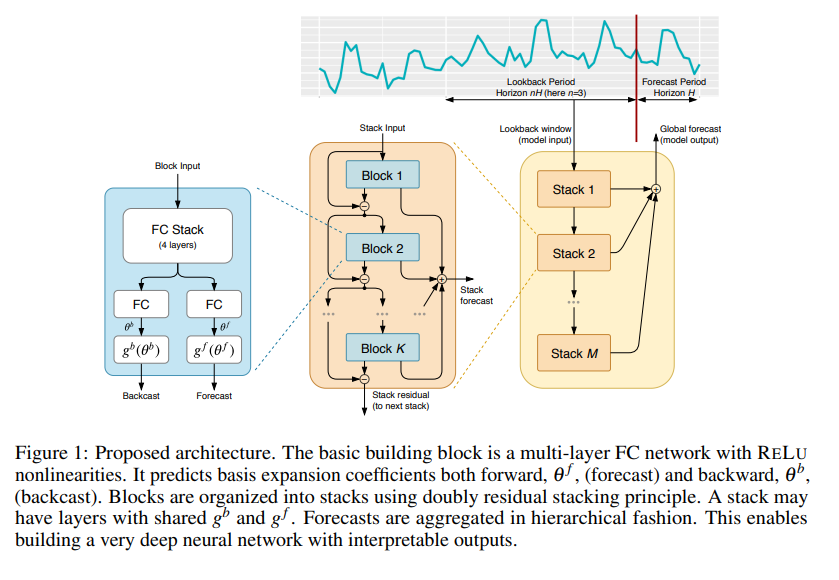

####NBeatBlock custom layer
we are going to subclass `tf.keras.layers.Layer` to create the NBeatsBlock layer to build the basic Block of our model since that Tensorflow doesn't have what we need.

`Layer` class: is a layer that encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a "call", the layer's forward pass).



In [99]:
class NBeatsBlock(tf.keras.layers.Layer):
  # In the constructor, the block architecture layers will be created

  def __init__(self,  # the constructor takes all the hyperparameters for the layer
               input_size:int,
               theta_size:int,
               horizon: int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # kwargs takes care of the parent's arguments like (name, trainable,...)
    super().__init__(**kwargs) # calling the parent's constructor
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
  
    # constructing the multi-layer FC network with relu activations:
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # the output of the block which theta_forcast/backcast will be extracted from
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name = "theta")

  def call(self, inputs): # the operations that our model will perform (i.e. the forwaed pass)
    # inputs : the historical Bitcoin data
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)
    # backcast (backwards predictions, shape: input_size) and forecast (forward predictions, shape: horizon)
    theta_forecast, thera_backcast = theta[:,-self.horizon:] , theta[:,:self.input_size]

    return thera_backcast,theta_forecast 

####Test the NBeatBlock custom layer

In [189]:
WINDOW_SIZE=7
HORIZON= 1

In [190]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast(window) + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)


dummy_data = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)

print(f"Dummy Data : {dummy_data}")
backcast, forecast = dummy_nbeats_block_layer(dummy_data)
print(f"Backcast : {backcast}")
print(f"forecast : {forecast}")

Dummy Data : [[1 2 3 4 5 6 7]]
Backcast : [[ 0.23572302  0.77497625 -0.47570285  0.70834684  0.42532474 -0.07960698
  -0.6291784 ]]
forecast : [[-0.49001354]]


####Preparing data for the N-BEATS algorithm using tf.data

In [191]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [192]:
#Creating windowed data as before:
bitcoin_prices_nbeats = bitcoin_prices.copy()
WINDOW_SIZE=7
HORIZON = 1
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [221]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [222]:
import tensorflow as tf

train_features_data = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_data = tf.data.Dataset.from_tensor_slices(y_train)

test_features_data = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_data = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_data, train_labels_data))
test_dataset = tf.data.Dataset.zip((test_features_data, test_labels_data))

BATCH_SIZE = 1024

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  =  test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

####Setting up hyperparameters for N-BEATS algorithm

from appendexD from the paper
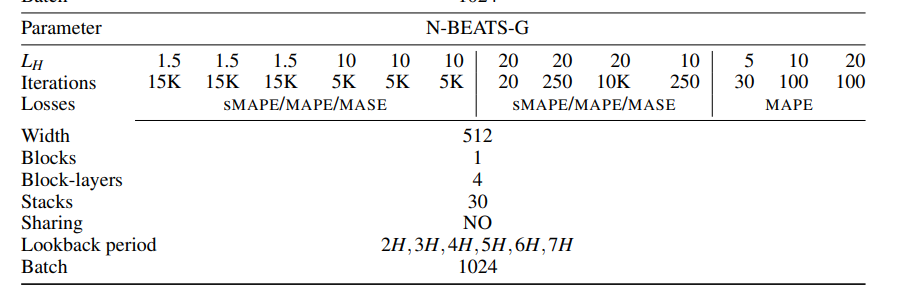

In [196]:
N_EPOCHS = 5000 # Iteration
N_NEURONS = 512 # Width
N_LAYERS = 4    # Block-layers
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # Lookback period : 7H
THETA_SIZE = INPUT_SIZE  + HORIZON


INPUT_SIZE, THETA_SIZE

(7, 8)

####Residual Connections:

there are two layers to build the "Doubly Residual Stacking", `tf.keras.layers.Add()` and `tf.keras.layers.Subtract()`.

- Subtract the backcast outputs from a previous block from the backcast inputs to the current block
- Add the forecast outputs from all blocks together in a stack

In [197]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

print(f"tensor_1 : {tensor_1}")
print(f"tensor_2 : {tensor_2}")
print(f"tensor_1 + tensor_2 : {tf.keras.layers.add([tensor_1, tensor_2])}")
print(f"tensor_2 - tensor_1 : {tf.keras.layers.subtract([tensor_1, tensor_2])}")

tensor_1 : [10 11 12 13 14 15 16 17 18 19]
tensor_2 : [0 1 2 3 4 5 6 7 8 9]
tensor_1 + tensor_2 : [10 12 14 16 18 20 22 24 26 28]
tensor_2 - tensor_1 : [10 10 10 10 10 10 10 10 10 10]


####Building the NBeats model:

construction steps:


1.   Setup NBeatsBlock (the initial block Block1 in graph)
2.   Create input layer to the Stack
3.   Make Initial backcast & forecast with the layer of step(1)
4.   Create a stack of Block layers using for-loop
5.   Use the NBeatsBlock to bulding the blocks of the stack
6.   Create Residual Stacking
7.   Put together inputs & outputs

In [198]:
%%time
# 1- setting up the initial block
tf.random.set_seed(42)

block1 = NBeatsBlock(input_size= INPUT_SIZE,
                     theta_size= THETA_SIZE,
                     horizon= HORIZON,
                     n_neurons= N_NEURONS,
                     n_layers= N_LAYERS,
                     name="InitialBlock")

# 2- input of the stack block
stack_input= tf.keras.Input(shape=(INPUT_SIZE), name= "Stack Input")

# 3- initial backacast and forecast.
backcast, block_forecast = block1(stack_input)
# first residual (subtract the stack_input from the block1's backcast output )
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4-Building the Stack of Blocks:
for i,_ in enumerate(range(N_STACKS-1)):
  backcast, forecast = NBeatsBlock(input_size= INPUT_SIZE,
                                    theta_size= THETA_SIZE,
                                    horizon= HORIZON,
                                    n_neurons= N_NEURONS,
                                    n_layers= N_LAYERS,
                                    name=f"Block{i}")(residuals) # passing the residuals (backcast after subtraction)
  
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")


model_7= tf.keras.Model(inputs=stack_input,
                        outputs= forecast,
                        name="model_7_N-BEATS")


model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

CPU times: user 1.86 s, sys: 11.5 ms, total: 1.87 s
Wall time: 1.9 s


In [199]:
%%time
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 635: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1167: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2613: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 17min 1s, sys: 23.8 s, total: 17min 24s
Wall time: 19min 43s


In [200]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 36ms/step - loss: 3.0641 - mae: 3.0641 - mse: 51.5764


[3.0640764236450195, 3.0640764236450195, 51.5764274597168]

In [201]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9291.553, 9201.942, 9369.7  , 9328.317, 9335.561, 9225.805,
       8795.034, 8797.889, 9081.415, 8711.559], dtype=float32)>

In [223]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 1715.5149,
 'mse': 9157753.0,
 'rmse': 3026.178,
 'mape': 7.555428,
 'mase': 3.0136845}

####Plotting the N-BEATS architecture we've created

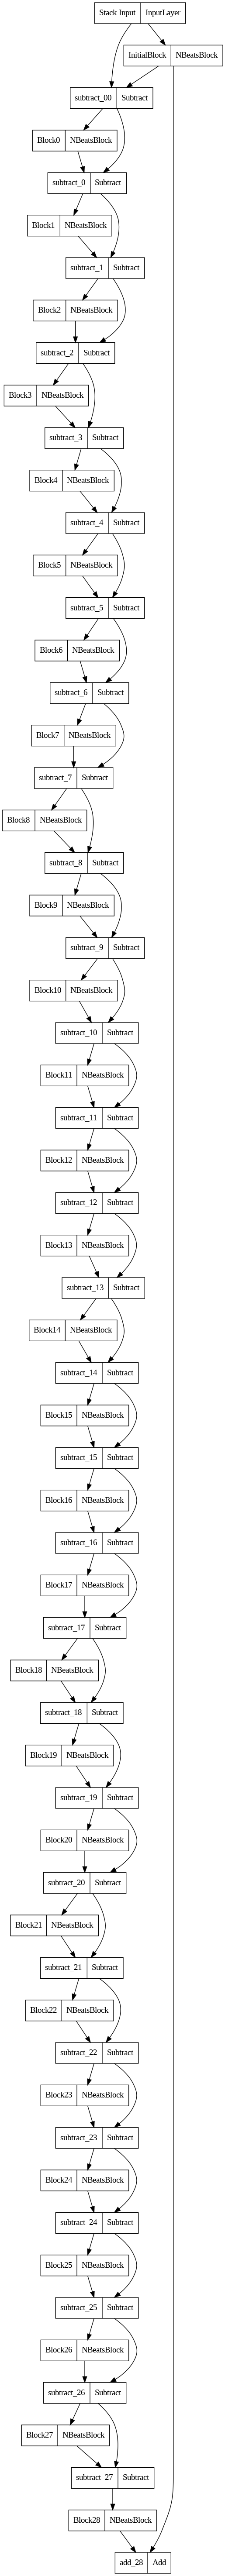

In [206]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

###Model 8: Creating an ensemble (stacking different models together)

The key idea is:
  combining different models to make some sort of dicision

In [226]:
# create a function that returns a list of trainded models 
def get_ensemble_models(horizon= HORIZON,
                        train_data= train_dataset,
                        test_data= test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  # if num_iterations = 10, then the function will return a list of 30 trained models(num_iterations*n_loss_functions)
  trained_models =[]
   # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(units= 128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(units= 128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(horizon)
      ],name="model_8_ensemble") 

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      model.fit(train_data,
                validation_data=test_data,
                epochs= num_epochs,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      trained_models.append(model)

  return trained_models
    

In [227]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)


Epoch 672: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 327: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 427: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 302: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 857: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 972: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 781: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 142: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 242: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 307: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 407: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 768: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 868: ReduceLROnPlateau reducing l

####Making predictions with an ensemble model

In [228]:
def make_ensemble_preds(ensemble_model, data):
  ensemble_preds=[]
  for model in ensemble_models:
    pred = model.predict(data)
    ensemble_preds.append(pred)

  return ensemble_preds

In [254]:
ensemble_preds = make_ensemble_preds(ensemble_model=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 6ms/step


[array([[ 8788.781 ],
        [ 8806.285 ],
        [ 9081.823 ],
        [ 8706.231 ],
        [ 8778.509 ],
        [ 8723.948 ],
        [ 8665.579 ],
        [ 8511.284 ],
        [ 8491.942 ],
        [ 8519.69  ],
        [ 8195.547 ],
        [ 8142.266 ],
        [ 8080.319 ],
        [ 7648.7983],
        [ 7282.3726],
        [ 7323.0845],
        [ 7139.61  ],
        [ 7243.197 ],
        [ 7145.5806],
        [ 7534.687 ],
        [ 7352.389 ],
        [ 7726.143 ],
        [ 7561.526 ],
        [ 7383.486 ],
        [ 7361.167 ],
        [ 7318.4062],
        [ 7220.6177],
        [ 7403.2896],
        [ 7491.732 ],
        [ 7529.267 ],
        [ 7551.974 ],
        [ 7322.194 ],
        [ 7241.483 ],
        [ 7172.31  ],
        [ 7202.1963],
        [ 7229.987 ],
        [ 7074.738 ],
        [ 7107.058 ],
        [ 6863.693 ],
        [ 6614.549 ],
        [ 7406.6304],
        [ 7176.4077],
        [ 7180.8066],
        [ 7247.958 ],
        [ 7154.534 ],
        [ 

####Evaluating the enemble models

In [249]:
model_8_results= evaluate_preds(y_true= tf.squeeze(y_test),
                                y_pred= np.median(ensemble_preds, axis=0))

model_8_results

{'mae': 19810.87,
 'mse': 699667200.0,
 'rmse': 26451.223,
 'mape': 97.60532,
 'mase': 34.80221}

####Plotting the prediction intervals (uncertainty estimates) of our ensemble


Knowing the range of values a model is predicting may help to make better decisions for forecasts.
These kind of prediction ranges are called "prediction intervals" or "uncertainty estimates"
we are going to replicate 95% prediction intervals.

The bootstrap method:
1.  Take the predictions from a number of randomly initialized models( our enesmble models)
2.  measure the standard deviation of the predictions.
3.  multiply the standard deviation by 1.96 as the 95% of observations fall within 1.96 standard deviation of the mean  (assuming the distribution of our model is Gaussian/Normal)
4. to get upper/lower bounds add/subtract value of point(3) to mean/median of predictions frpm point(1)

In [258]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

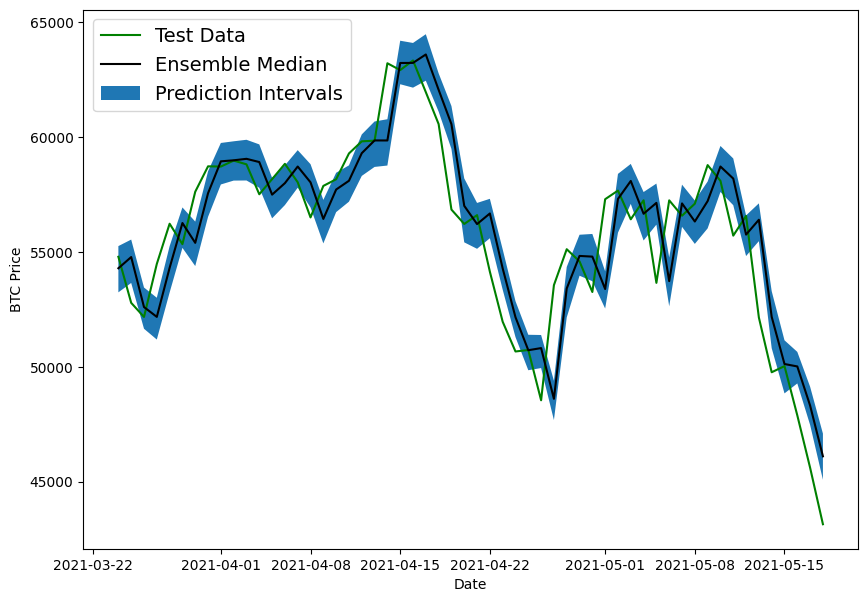

In [278]:
import numpy as np
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                tf.squeeze((lower)[offset:]), 
                tf.squeeze((upper)[offset:]), label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

###Model 9: Train a model on the full historical data to make predictions into future

train the model on the whole data (i.e no test data) we will use the model on the real future not pseudo-future
>  Forecasting models need to be retrained every time a forecast is made.
> When a new price comes out (e.g. the next day), we'll have to retrain our model to incorporate that new price to predict the next forecast.

In [118]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,,
2013-10-01,123.65499,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-05,121.33866,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN


In [119]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"],axis= 1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

####preparing data 

In [120]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

train_dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
train_dataset_all = train_dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

####building model_9

model_9 is similar to model_1,  except with an extra layer.

In [121]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
])

model_9.compile(loss="mae",
                optimizer= tf.keras.optimizers.Adam())

model_9.fit(train_dataset_all,
            epochs=100,
            verbose=0)

####Make predictions on the future:

replicating the following figure:
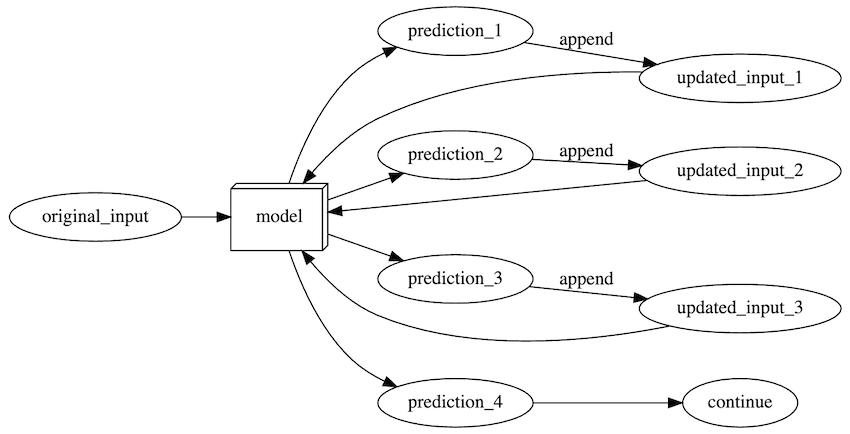

In [164]:
INTO_FUTURE = 14 # How many timesteps to predict into the future? -> 14-days

In [165]:
# create a function which returns INTO_FUTURE forecasted values using a trained model
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE)->list:
  updated_input = values[-window_size:]
  forecasts = []
  for _ in range(into_future):
    pred = model.predict(tf.expand_dims(updated_input, axis=0))
    print(f"Predicting on: \n {updated_input} -> Prediction: {tf.squeeze(pred).numpy()}\n")
    forecasts.append(tf.squeeze(pred).numpy())
    
    updated_input= np.append(updated_input, pred)[-window_size:]

    # retrain the model with the updated_input
    # new_data = np.append(values, pred)
    # new_dataset = tf.data.Dataset.from_tensor_slices(new_data)
    # model = model.fit(new_data,
    #                   epochs=100,
    #                   verbose=0)
  return forecasts

In [166]:
future_forecats = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55062.6875

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55062.6875    ] -> Prediction: 51373.84375

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55062.6875     51373.84375   ] -> Prediction: 49797.0625

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55062.6875     51373.84375    49797.0625    ] -> Prediction: 46909.3671875

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55062.6875
 51373.84375    49797.0625     46909.3671875 ] -> Pred

In [167]:
future_forecats[:10]

[55062.688,
 51373.844,
 49797.062,
 46909.367,
 47090.08,
 47122.86,
 46949.6,
 53534.566,
 49948.582,
 48718.406]

####Plot future forecasts

In [168]:
# we need a series of future dates:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future,"D")

  return np.arange(start_date, end_date, dtype= 'datetime64[D]')

In [169]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [170]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [171]:
# insert the last timestep and Bitcoin price of our training data to the next_time_steps and future_forecast arrays.
next_time_steps = np.insert(next_time_steps, 0 , last_timestep)
future_forecats = np.insert(future_forecats, 0 , btc_price[-1])

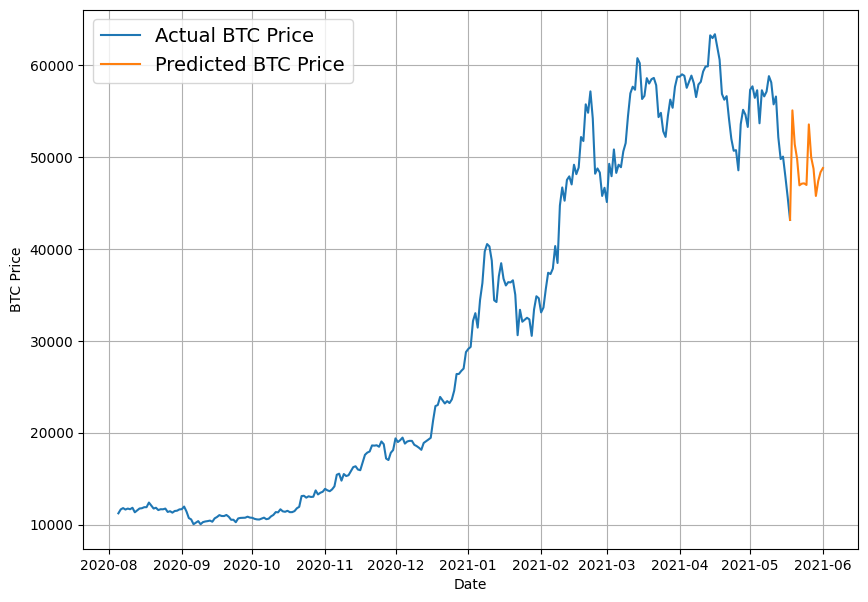

In [172]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecats, format="-", label="Predicted BTC Price")


###Model 10: The Turkey problem 🦃

You could have the historical data of Bitcoin for its entire existence and build a model which predicts it perfectly.

But then one day for some unknown and unpredictable reason, the price of Bitcoin plummets 100x in a single day.

In [176]:
# manufacture a highly unlikely data point into the historical price of Bitcoin, the price falling 100x in one day.
btc_price_turkey = btc_price.copy()

btc_price_turkey[-1] = btc_price_turkey[-1]/100
btc_timesteps_turkey = np.array(bitcoin_prices.index)

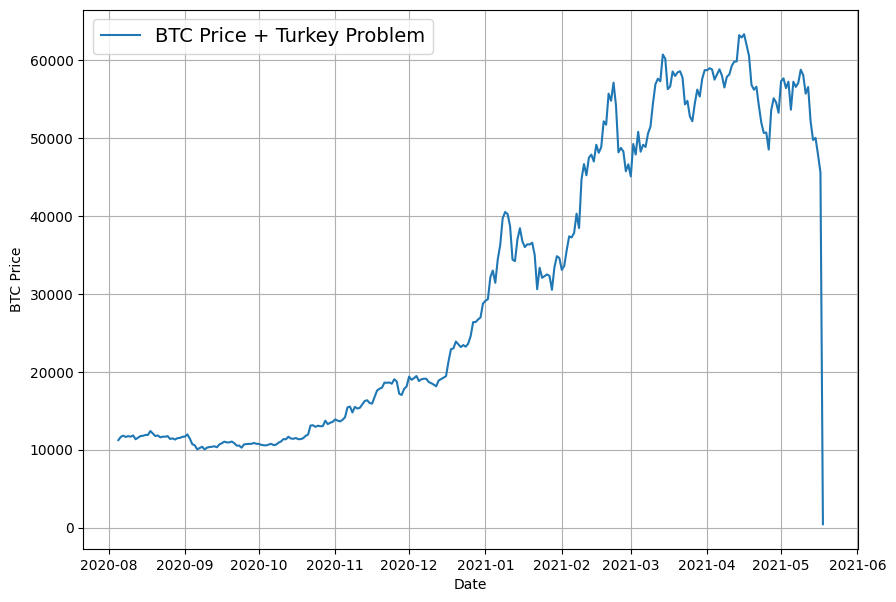

In [178]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

####creating windowed datasets of turkey data

In [179]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

window_step : [[0 1 2 3 4 5 6 7]]
window_indicies : [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]
Windowed array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361   431.44471291]]


(2224, 556, 2224, 556)

####Building a turkey model (model to predict on turkey data)

In [181]:
# the turkey_model is a clone of model_1 (same architecture, but different data)
model_10 = tf.keras.models.clone_model(model_1)
model_10._name = "Turkey_Model"

model_10.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

model_10.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(model_10.name)])

In [182]:
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 730.9832


730.9832153320312

In [183]:
model_10 = tf.keras.models.load_model("/content/model_experiments/Turkey_Model")

model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 638.1872


638.1871948242188

In [185]:
turkey_preds = make_preds(model_10,X_test)

18/18 [==============================] - 0s 4ms/step


In [186]:
turkey_results = evaluate_preds(y_true= y_test,
                                y_pred= turkey_preds)
turkey_results

{'mae': 17131.154,
 'mse': 614519230.0,
 'rmse': 23716.988,
 'mape': 121.38911,
 'mase': 26.510517}

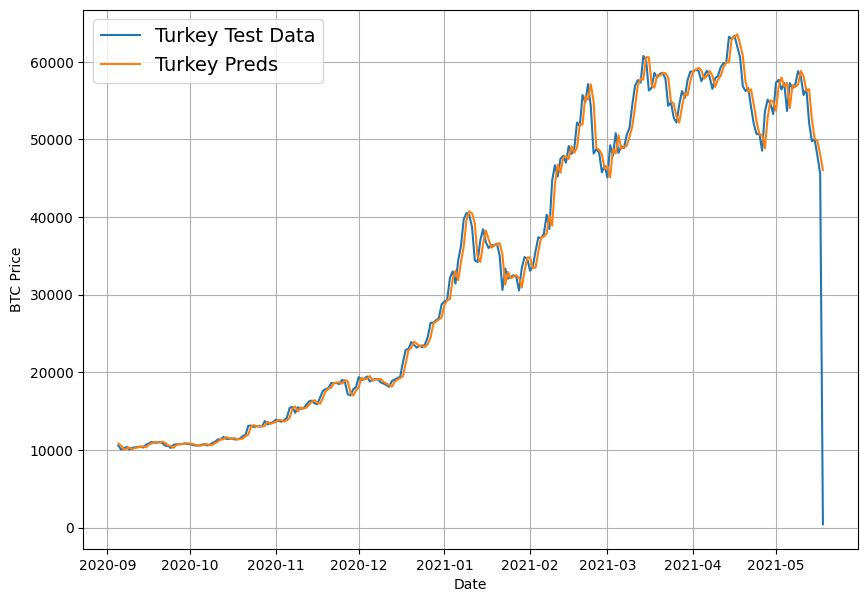

In [188]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 format="-",
                 label="Turkey Preds", 
                 start=offset);